In [1]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.regression.linear_model import yule_walker
from scipy.ndimage import uniform_filter1d
from eofs.standard import Eof
from statsmodels.tsa.stattools import pacf,acf
from scipy.optimize import curve_fit
from scipy.interpolate import RegularGridInterpolator
from matplotlib import mlab
import netCDF4 as nc
from scipy.ndimage import gaussian_filter
from scipy.signal import detrend, welch
from statsmodels.graphics.tsaplots import plot_acf
from scipy.fft import fft, fftfreq

%matplotlib widget


# Detrending and de-seasonalizing

In [2]:
# ds = nc.Dataset('/Users/alfredhansen/Documents/Files/MSc_thesis/NoiseField/NoiseFieldCode/Land_and_Ocean_LatLong1.nc')
ds = nc.Dataset('HEAVY--Land_and_Ocean_LatLong1.nc')
land_mask = ds['land_mask']
temp = ds['temperature']
temp_array = np.asarray(ds['temperature'])
timesteps = ds['time']
len_time = len(timesteps)

temp_an_series = np.zeros(len_time)
temp_filled= np.zeros([len_time,180,360])
for i in range(len_time):
    temp_filled[i] = np.roll(np.flipud(temp[i].filled(fill_value = 9.969209968386869e-36)),93)
    temp_array[i] = np.roll(np.flipud(temp_array[i]),93)
temp_filled = temp_filled[30*12:]

/var/folders/5k/p5gdyj_n6vgfb8n0ht9rc0sm0000gn/T/ipykernel_578/2389905463.py:4: UserWarning: WARNING: valid_min not used since it
cannot be safely cast to variable data type
  temp_array = np.asarray(ds['temperature'])
/var/folders/5k/p5gdyj_n6vgfb8n0ht9rc0sm0000gn/T/ipykernel_578/2389905463.py:4: UserWarning: WARNING: valid_max not used since it
cannot be safely cast to variable data type
  temp_array = np.asarray(ds['temperature'])
/var/folders/5k/p5gdyj_n6vgfb8n0ht9rc0sm0000gn/T/ipykernel_578/2389905463.py:11: UserWarning: WARNING: valid_min not used since it
cannot be safely cast to variable data type
  temp_filled[i] = np.roll(np.flipud(temp[i].filled(fill_value = 9.969209968386869e-36)),93)
/var/folders/5k/p5gdyj_n6vgfb8n0ht9rc0sm0000gn/T/ipykernel_578/2389905463.py:11: UserWarning: WARNING: valid_max not used since it
cannot be safely cast to variable data type
  temp_filled[i] = np.roll(np.flipud(temp[i].filled(fill_value = 9.969209968386869e-36)),93)


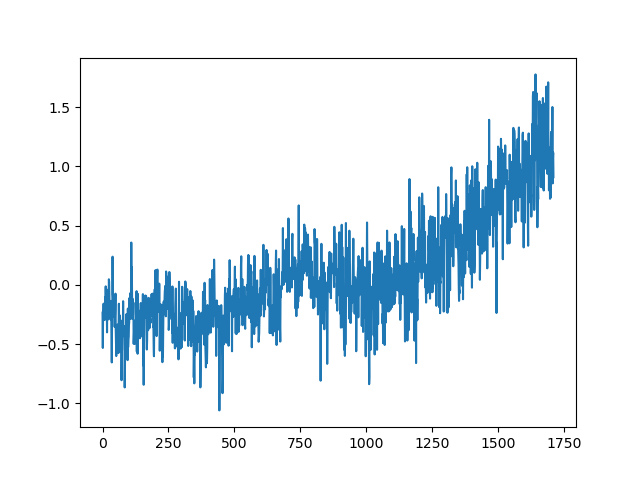

In [3]:
plt.figure()
plt.plot(np.nanmean(temp_filled,axis = (1,2)))
plt.show()

## Detrending functions

In [4]:

def detrend_data(temp_filled, window_size):
    half_window = int(window_size/2) 
    simple_detrend = np.zeros_like(temp_filled)
    for t in range(np.shape(temp_filled)[0]):
        if t-half_window <=0:
            simple_detrend[t,:,:] = temp_filled[t,:,:] - np.mean(temp_filled[:t+half_window:12,:,:], axis = 0)
        elif t+half_window >= np.shape(temp_filled)[0]:
            simple_detrend[t,:,:] = temp_filled[t,:,:] - np.mean(temp_filled[t-half_window::12,:,:], axis = 0)
        else:
            simple_detrend[t,:,:] = temp_filled[t,:,:] - np.mean(temp_filled[t-half_window:t+half_window:12,:,:], axis = 0)
    return simple_detrend

def non_season_detrend(temp_filled, window_size):
    half_window = int(window_size/2) 
    simple_detrend = np.zeros_like(temp_filled)
    for t in range(np.shape(temp_filled)[0]):
        if t-half_window <=0:
            simple_detrend[t,:,:] = temp_filled[t,:,:] - np.mean(temp_filled[:t+half_window,:,:], axis = 0)
        elif t+half_window >= np.shape(temp_filled)[0]:
            simple_detrend[t,:,:] = temp_filled[t,:,:] - np.mean(temp_filled[t-half_window:,:,:], axis = 0)
        else:
            simple_detrend[t,:,:] = temp_filled[t,:,:] - np.mean(temp_filled[t-half_window:t+half_window,:,:], axis = 0)
    return simple_detrend    

def diff_detrend(temp_filled, window_size):
    #detrended = non_season_detrend(temp_filled,window_size)
    simple_detrend = np.asarray([temp_filled[i]-temp_filled[i-12] for i in range(12,np.shape(temp_filled)[0])])
    return simple_detrend 


    

In [6]:
diff_detrended = diff_detrend(temp_filled, 30)

In [7]:
detrend_4 = detrend_data(temp_filled, 12*4)

In [5]:
detrend_10 = detrend_data(temp_filled, 12*10)

In [8]:
detrend_20 = detrend_data(temp_filled, 12*20)

In [9]:
detrend_30 = detrend_data(temp_filled, 12*30)

# GLOBAL AND N. HEM. TIME SERIES ANF SPECTRA

In [10]:
raw_global_temp = np.nanmean(temp_filled,axis = (1,2))
raw_global_temp_N = np.nanmean(temp_filled[:,:90],axis = (1,2))

simple_global_temp_4 = np.nanmean(detrend_4,axis = (1,2))
simple_global_temp_10 = np.nanmean(detrend_10,axis = (1,2))
simple_global_temp_20 = np.nanmean(detrend_20,axis = (1,2))
simple_global_temp_30 = np.nanmean(detrend_30,axis = (1,2))

simple_global_temp_4_N = np.nanmean(detrend_4[:,:90],axis = (1,2))
simple_global_temp_10_N = np.nanmean(detrend_10[:,:90],axis = (1,2))
simple_global_temp_20_N = np.nanmean(detrend_20[:,:90],axis = (1,2))
simple_global_temp_30_N = np.nanmean(detrend_30[:,:90],axis = (1,2))


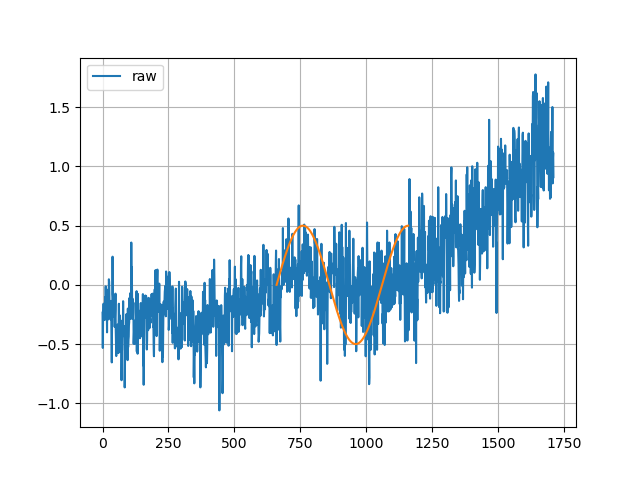

In [11]:
#Indicate that above T = 400 mo we are just capturing gloabl warming in the 'bump', and so at least up to 360 months we are not capyuring global warming.

x_osc = np.arange(0,500)
omega = 2*np.pi/400
y_osc = np.sin(x_osc*omega)

plt.figure()
plt.plot(gaussian_filter(raw_global_temp,0), label = 'raw')
plt.plot(660+x_osc,y_osc*0.5)
""" plt.plot(gaussian_filter(simple_global_temp_30,2), label = 'full detrend 30')
plt.plot(gaussian_filter(simple_global_temp_20,2), label = 'full detrend 20')
plt.plot(gaussian_filter(simple_global_temp_10,2), label = 'full detrend 10')
plt.plot(gaussian_filter(simple_global_temp_4,2), label = 'full detrend 4')
plt.plot(gaussian_filter(np.mean(diff_detrended, axis = (1,2)),2), label = 'diff') """
plt.grid(alpha = 0.95)
plt.legend()
plt.show()

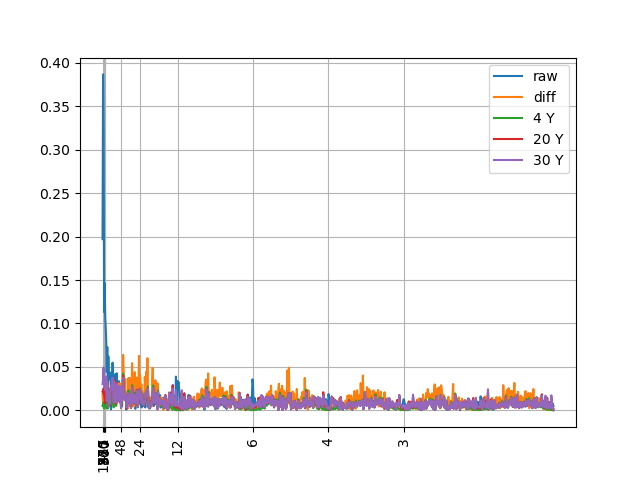

In [20]:
fft_raw = fft(raw_global_temp)
fft_diff = fft(np.mean(diff_detrended[:,:], axis = (1,2)))
fft_4 = fft(simple_global_temp_4)
fft_10 = fft(simple_global_temp_10)
fft_20 = fft(simple_global_temp_20)
fft_30 = fft(simple_global_temp_30)

N = np.shape(temp_filled)[0]
T = 1/12
freqs = fftfreq(N, T)[:N//2]

plt.figure()
plt.plot(freqs,2.0/N * np.abs(fft_raw[0:N//2]),label = 'raw')
plt.plot(freqs,2.0/N * np.abs(fft_diff[0:N//2]),label = 'diff')
plt.plot(freqs,2.0/N * np.abs(fft_4[0:N//2]),label = '4 Y')
#plt.plot(freqs,2.0/N * np.abs(fft_10[0:N//2]),label = '10 Y')
plt.plot(freqs,2.0/N * np.abs(fft_20[0:N//2]),label = '20 Y')
plt.plot(freqs,2.0/N * np.abs(fft_30[0:N//2]),label = '30 Y')




months = [N//4,N//3,N//2,N,30*12,12,24,48,6,3,4]
freq = [12/(i) for i in months]
label = [str(i) for i in months]
plt.xticks(freq,label,rotation = 90)
plt.grid(alpha = 0.95)
plt.legend()
plt.show()

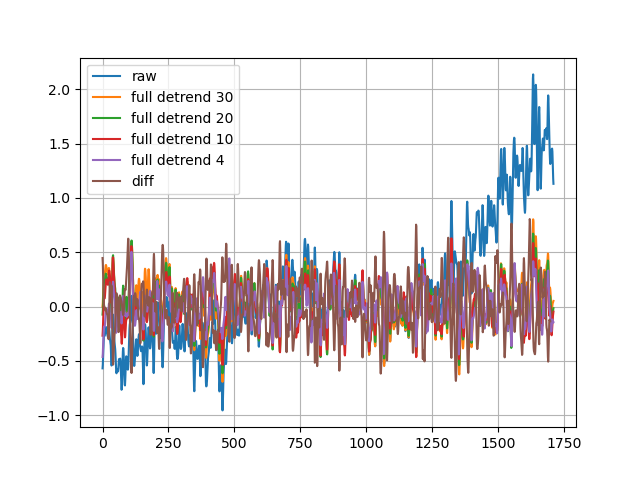

In [149]:
plt.figure()
plt.plot(gaussian_filter(raw_global_temp_N,2), label = 'raw')
plt.plot(gaussian_filter(simple_global_temp_30_N,2), label = 'full detrend 30')
plt.plot(gaussian_filter(simple_global_temp_20_N,2), label = 'full detrend 20')
plt.plot(gaussian_filter(simple_global_temp_10_N,2), label = 'full detrend 10')
plt.plot(gaussian_filter(simple_global_temp_4_N,2), label = 'full detrend 4')
plt.plot(gaussian_filter(np.mean(diff_detrended[:,:90], axis = (1,2)),2), label = 'diff')
plt.grid(alpha = 0.95)
plt.legend()
plt.show()

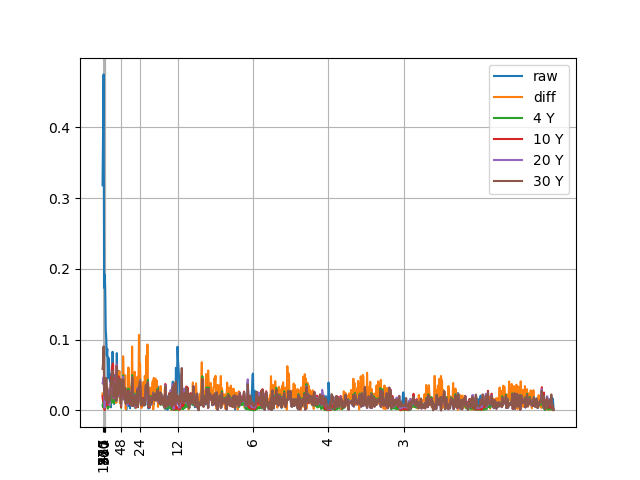

In [21]:
fft_raw = fft(raw_global_temp_N)
fft_diff = fft(np.mean(diff_detrended[:,:90,:], axis = (1,2)))
fft_4 = fft(simple_global_temp_4_N)
fft_10 = fft(simple_global_temp_10_N)
fft_20 = fft(simple_global_temp_20_N)
fft_30 = fft(simple_global_temp_30_N)

N = np.shape(temp_filled)[0]
T = 1/12
freqs = fftfreq(N, T)[:N//2]

plt.figure()
plt.plot(freqs,2.0/N * np.abs(fft_raw[0:N//2]),label = 'raw')
plt.plot(freqs,2.0/N * np.abs(fft_diff[0:N//2]),label = 'diff')
plt.plot(freqs,2.0/N * np.abs(fft_4[0:N//2]),label = '4 Y')
plt.plot(freqs,2.0/N * np.abs(fft_10[0:N//2]),label = '10 Y')
plt.plot(freqs,2.0/N * np.abs(fft_20[0:N//2]),label = '20 Y')
plt.plot(freqs,2.0/N * np.abs(fft_30[0:N//2]),label = '30 Y')



months = [N//4,N//3,N//2,N,30*12,12,24,48,6,3,4]
freq = [12/(i) for i in months]
label = [str(i) for i in months]
plt.xticks(freq,label,rotation = 90)
plt.grid(alpha = 0.95)
plt.legend()
plt.show()

# INVESTIGATING GRID POINTS

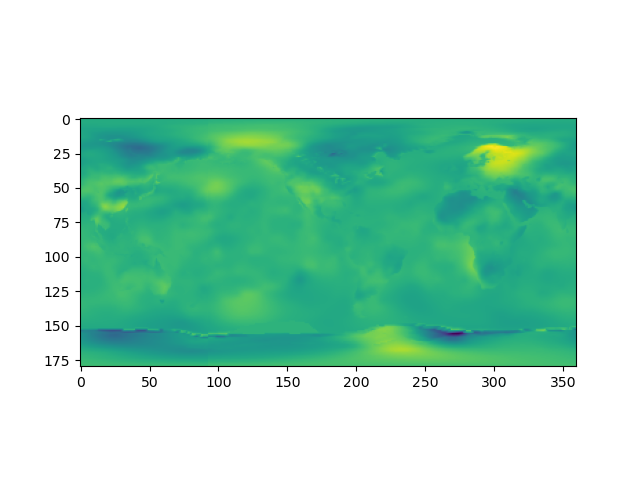

In [156]:
plt.figure()
plt.imshow(temp_filled[1000])
plt.show()

CHecking in the Arctic: We have some missing data but big seasonal cycle. This is removed by all detrending methods, and the spectrum is nicely reprduced by all yearly detrending up until large periods where the 20 and 30 year windows performe the best.

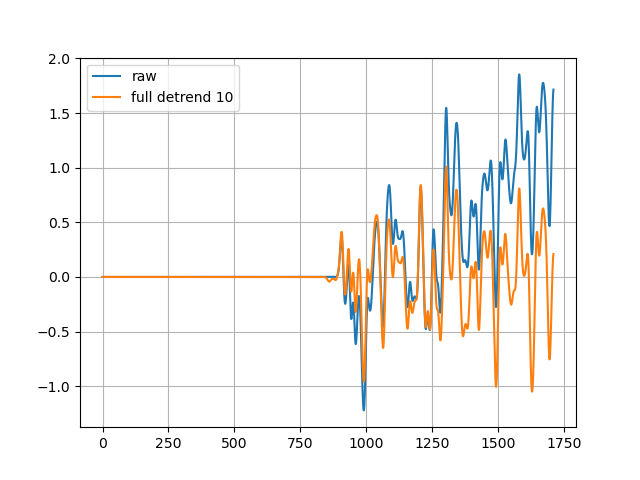

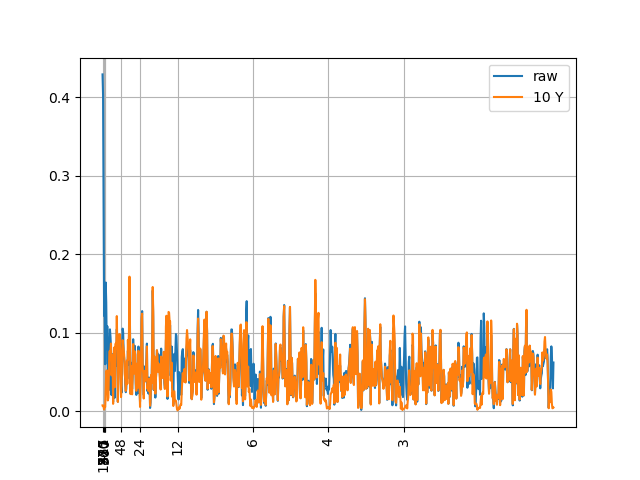

In [49]:
lat = 175
lon = 150

# SMOOTHED TEMP TO SEE DETREND
plt.figure()
plt.plot(gaussian_filter(temp_filled[:,lat,lon],6), label = 'raw')
#plt.plot(np.arange(12,np.shape(temp_filled)[0]),gaussian_filter(diff_detrended[:,lat,lon],6), label = 'diff')
#plt.plot(gaussian_filter(detrend_30[:,lat,lon],6), label = 'full detrend 30')
#plt.plot(gaussian_filter(detrend_20[:,lat,lon],6), label = 'full detrend 20')
plt.plot(gaussian_filter(detrend_10[:,lat,lon],6), label = 'full detrend 10')
#plt.plot(gaussian_filter(detrend_4[:,lat,lon],6), label = 'full detrend 4')
plt.grid(alpha = 0.95)
plt.legend()
plt.show()

# FREQUENCY PLOTS

fft_raw = fft(temp_filled[:,lat,lon])
fft_diff = fft(diff_detrended[:,lat,lon])
fft_5 = fft(detrend_4[:,lat,lon])
fft_10 = fft(detrend_10[:,lat,lon])
fft_20 = fft(detrend_20[:,lat,lon])
fft_30 = fft(detrend_30[:,lat,lon])

N = np.shape(temp_filled)[0]
T = 1/12
freqs = fftfreq(N, T)[:N//2]
N_diff = np.shape(temp_filled)[0]-12
freqs_diff = fftfreq(N_diff, T)[:N_diff//2]

plt.figure()
#plt.plot(freqs_diff,2.0/N_diff * np.abs(fft_diff[0:N_diff//2]),label = 'diff')
plt.plot(freqs,2.0/N * np.abs(fft_raw[0:N//2]),label = 'raw')
#plt.plot(freqs,2.0/N * np.abs(fft_5[0:N//2]),label = '4 Y')
plt.plot(freqs,2.0/N * np.abs(fft_10[0:N//2]),label = '10 Y')
#plt.plot(freqs,2.0/N * np.abs(fft_20[0:N//2]),label = '20 Y')
#plt.plot(freqs,2.0/N * np.abs(fft_30[0:N//2]),label = '30 Y')

months = [N//4,N//3,N//2,N,30*12,12,24,48,6,3,4]
freq = [12/(i) for i in months]
label = [str(i) for i in months]
plt.xticks(freq,label,rotation = 90)
plt.grid(alpha = 0.95)
plt.legend()
plt.show()

Checking the southern atlantic ocean to see that we remove seasonality over ocean also. Clear seasonal cycle is removed and the same analysis from above holds. Time seres of detrended seem stationary for all choises

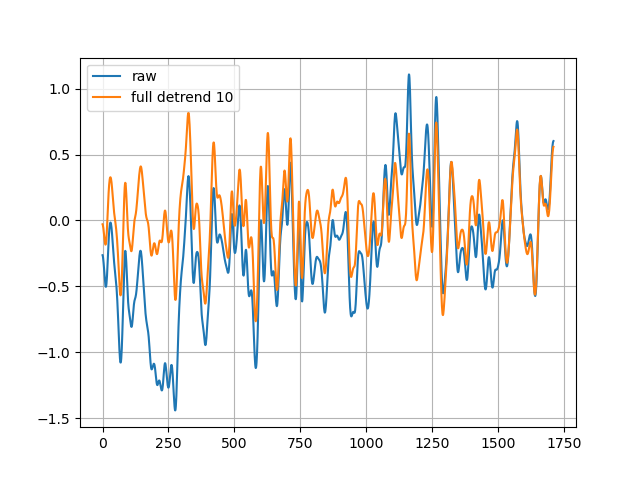

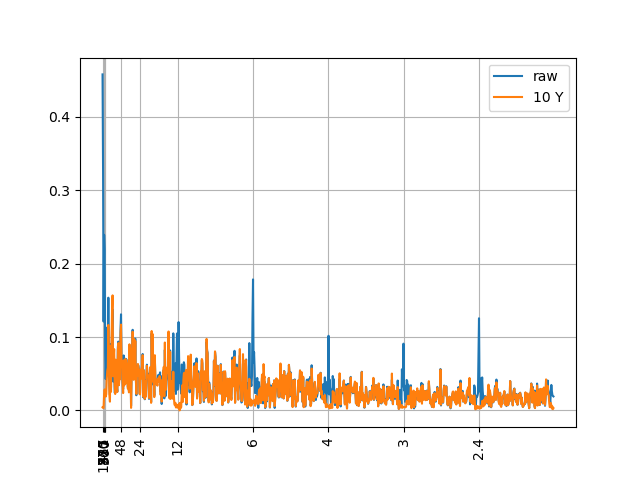

In [50]:
lat = 140
lon = 255

# SMOOTHED TEMP TO SEE DETREND
plt.figure()
plt.plot(gaussian_filter(temp_filled[:,lat,lon],6), label = 'raw')
#plt.plot(np.arange(12,np.shape(temp_filled)[0]),gaussian_filter(diff_detrended[:,lat,lon],6), label = 'diff')
#plt.plot(gaussian_filter(detrend_30[:,lat,lon],6), label = 'full detrend 30')
#plt.plot(gaussian_filter(detrend_20[:,lat,lon],6), label = 'full detrend 20')
plt.plot(gaussian_filter(detrend_10[:,lat,lon],6), label = 'full detrend 10')
#plt.plot(gaussian_filter(detrend_4[:,lat,lon],6), label = 'full detrend 4')
plt.grid(alpha = 0.95)
plt.legend()
plt.show()

# FREQUENCY PLOTS

fft_raw = fft(temp_filled[:,lat,lon])
fft_diff = fft(diff_detrended[:,lat,lon])
fft_5 = fft(detrend_4[:,lat,lon])
fft_10 = fft(detrend_10[:,lat,lon])
fft_20 = fft(detrend_20[:,lat,lon])
fft_30 = fft(detrend_30[:,lat,lon])

N = np.shape(temp_filled)[0]
T = 1/12
freqs = fftfreq(N, T)[:N//2]

N_diff = np.shape(temp_filled)[0]-12
freqs_diff = fftfreq(N_diff, T)[:N_diff//2]

plt.figure()
#plt.plot(freqs_diff,2.0/N_diff * np.abs(fft_diff[0:N_diff//2]),label = 'diff')
plt.plot(freqs,2.0/N * np.abs(fft_raw[0:N//2]),label = 'raw')
#plt.plot(freqs,2.0/N * np.abs(fft_5[0:N//2]),label = '4 Y')
plt.plot(freqs,2.0/N * np.abs(fft_10[0:N//2]),label = '10 Y')
#plt.plot(freqs,2.0/N * np.abs(fft_20[0:N//2]),label = '20 Y')
#plt.plot(freqs,2.0/N * np.abs(fft_30[0:N//2]),label = '30 Y')

months = [N//4,N//3,N//2,N,30*12,12,24,48,6,3,4,2.4]
freq = [12/(i) for i in months]
label = [str(i) for i in months]
plt.xticks(freq,label,rotation = 90)
plt.grid(alpha = 0.95)
plt.legend()
plt.show()

Checking northern atlantic

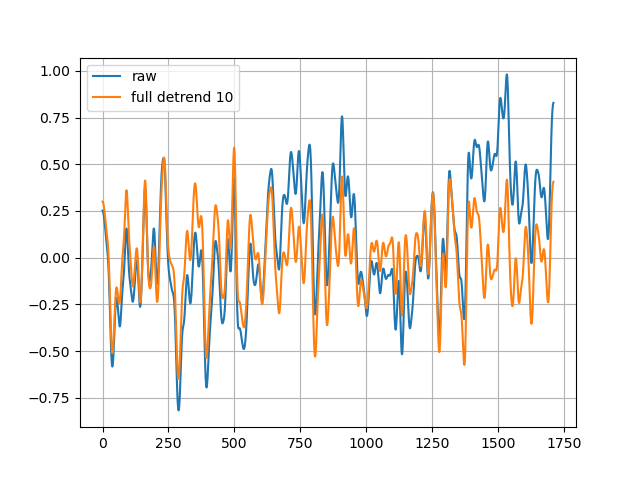

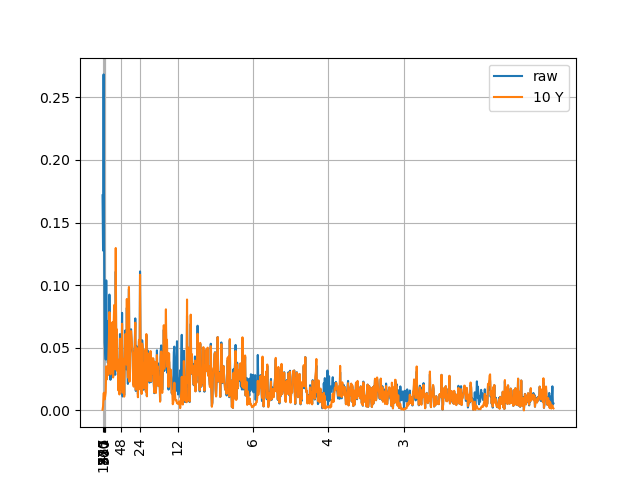

In [51]:
lat = 40
lon = 255

# SMOOTHED TEMP TO SEE DETREND
plt.figure()
plt.plot(gaussian_filter(temp_filled[:,lat,lon],6), label = 'raw')
#plt.plot(np.arange(12,np.shape(temp_filled)[0]),gaussian_filter(diff_detrended[:,lat,lon],6), label = 'diff')
#plt.plot(gaussian_filter(detrend_30[:,lat,lon],6), label = 'full detrend 30')
#plt.plot(gaussian_filter(detrend_20[:,lat,lon],6), label = 'full detrend 20')
plt.plot(gaussian_filter(detrend_10[:,lat,lon],6), label = 'full detrend 10')
#plt.plot(gaussian_filter(detrend_4[:,lat,lon],6), label = 'full detrend 4')
plt.grid(alpha = 0.95)
plt.legend()
plt.show()

# FREQUENCY PLOTS

fft_raw = fft(temp_filled[:,lat,lon])
fft_diff = fft(diff_detrended[:,lat,lon])
fft_5 = fft(detrend_4[:,lat,lon])
fft_10 = fft(detrend_10[:,lat,lon])
fft_20 = fft(detrend_20[:,lat,lon])
fft_30 = fft(detrend_30[:,lat,lon])

N = np.shape(temp_filled)[0]
T = 1/12
freqs = fftfreq(N, T)[:N//2]

N_diff = np.shape(temp_filled)[0]-12
freqs_diff = fftfreq(N_diff, T)[:N_diff//2]

plt.figure()
#plt.plot(freqs_diff,2.0/N_diff * np.abs(fft_diff[0:N_diff//2]),label = 'diff')
plt.plot(freqs,2.0/N * np.abs(fft_raw[0:N//2]),label = 'raw')
#plt.plot(freqs,2.0/N * np.abs(fft_5[0:N//2]),label = '4 Y')
plt.plot(freqs,2.0/N * np.abs(fft_10[0:N//2]),label = '10 Y')
#plt.plot(freqs,2.0/N * np.abs(fft_20[0:N//2]),label = '20 Y')
#plt.plot(freqs,2.0/N * np.abs(fft_30[0:N//2]),label = '30 Y')

months = [N//4,N//3,N//2,N,30*12,12,24,48,6,3,4]
freq = [12/(i) for i in months]
label = [str(i) for i in months]
plt.xticks(freq,label,rotation = 90)
plt.grid(alpha = 0.95)
plt.legend()
plt.show()

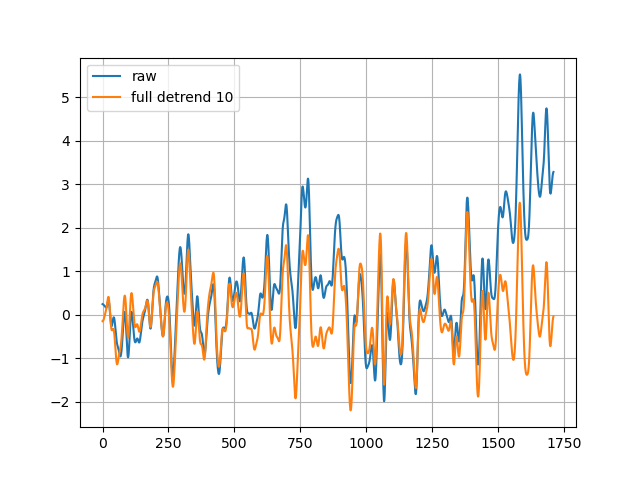

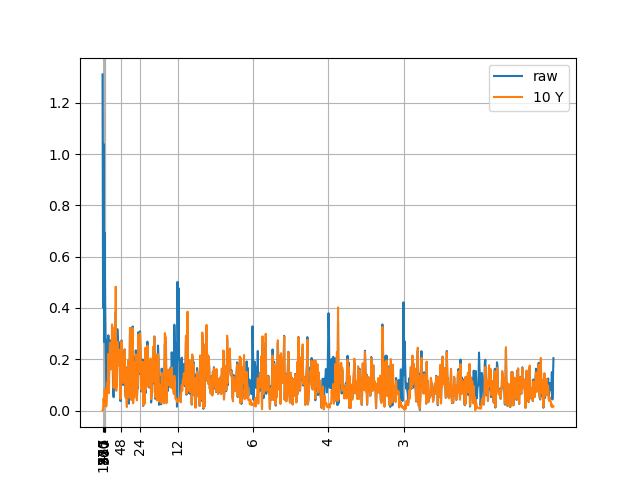

In [52]:
lat = 15
lon = 355

# SMOOTHED TEMP TO SEE DETREND
plt.figure()
plt.plot(gaussian_filter(temp_filled[:,lat,lon],6), label = 'raw')
#plt.plot(np.arange(12,np.shape(temp_filled)[0]),gaussian_filter(diff_detrended[:,lat,lon],6), label = 'diff')
#plt.plot(gaussian_filter(detrend_30[:,lat,lon],6), label = 'full detrend 30')
#plt.plot(gaussian_filter(detrend_20[:,lat,lon],6), label = 'full detrend 20')
plt.plot(gaussian_filter(detrend_10[:,lat,lon],6), label = 'full detrend 10')
#plt.plot(gaussian_filter(detrend_4[:,lat,lon],6), label = 'full detrend 4')
plt.grid(alpha = 0.95)
plt.legend()
plt.show()

# FREQUENCY PLOTS

fft_raw = fft(temp_filled[:,lat,lon])
fft_diff = fft(diff_detrended[:,lat,lon])
fft_5 = fft(detrend_4[:,lat,lon])
fft_10 = fft(detrend_10[:,lat,lon])
fft_20 = fft(detrend_20[:,lat,lon])
fft_30 = fft(detrend_30[:,lat,lon])

N = np.shape(temp_filled)[0]
T = 1/12
freqs = fftfreq(N, T)[:N//2]

N_diff = np.shape(temp_filled)[0]-12
freqs_diff = fftfreq(N_diff, T)[:N_diff//2]

plt.figure()
#plt.plot(freqs_diff,2.0/N_diff * np.abs(fft_diff[0:N_diff//2]),label = 'diff')
plt.plot(freqs,2.0/N * np.abs(fft_raw[0:N//2]),label = 'raw')
#plt.plot(freqs,2.0/N * np.abs(fft_5[0:N//2]),label = '4 Y')
plt.plot(freqs,2.0/N * np.abs(fft_10[0:N//2]),label = '10 Y')
#plt.plot(freqs,2.0/N * np.abs(fft_20[0:N//2]),label = '20 Y')
#plt.plot(freqs,2.0/N * np.abs(fft_30[0:N//2]),label = '30 Y')

months = [N//4,N//3,N//2,N,30*12,12,24,48,6,3,4]
freq = [12/(i) for i in months]
label = [str(i) for i in months]
plt.xticks(freq,label,rotation = 90)
plt.grid(alpha = 0.95)
plt.legend()
plt.show()

Looking at arctic again where we have a clear linear trend that is much longer than the trend in the global temp. anom. showing that for the strong trend case we remove it and for spectrum 30 year captures varibality up to 360 months nicely and removes seasonality

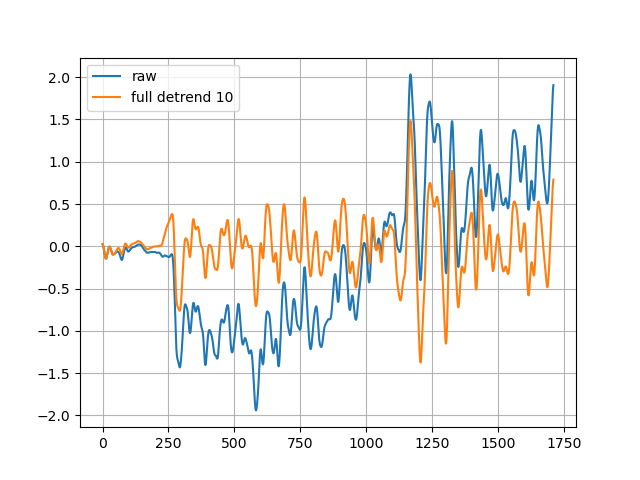

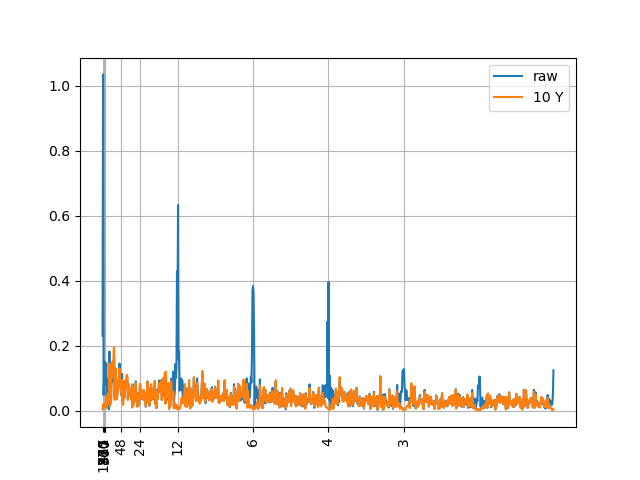

In [53]:
lat = 149
lon = 250

# SMOOTHED TEMP TO SEE DETREND
plt.figure()
plt.plot(gaussian_filter(temp_filled[:,lat,lon],6), label = 'raw')
#plt.plot(np.arange(12,np.shape(temp_filled)[0]),gaussian_filter(diff_detrended[:,lat,lon],6), label = 'diff')
#plt.plot(gaussian_filter(detrend_30[:,lat,lon],6), label = 'full detrend 30')
#plt.plot(gaussian_filter(detrend_20[:,lat,lon],6), label = 'full detrend 20')
plt.plot(gaussian_filter(detrend_10[:,lat,lon],6), label = 'full detrend 10')
#plt.plot(gaussian_filter(detrend_4[:,lat,lon],6), label = 'full detrend 4')
plt.grid(alpha = 0.95)
plt.legend()
plt.show()

# FREQUENCY PLOTS

fft_raw = fft(temp_filled[:,lat,lon])
fft_diff = fft(diff_detrended[:,lat,lon])
fft_5 = fft(detrend_4[:,lat,lon])
fft_10 = fft(detrend_10[:,lat,lon])
fft_20 = fft(detrend_20[:,lat,lon])
fft_30 = fft(detrend_30[:,lat,lon])

N = np.shape(temp_filled)[0]
T = 1/12
freqs = fftfreq(N, T)[:N//2]

N_diff = np.shape(temp_filled)[0]-12
freqs_diff = fftfreq(N_diff, T)[:N_diff//2]

plt.figure()
#plt.plot(freqs_diff,2.0/N_diff * np.abs(fft_diff[0:N_diff//2]),label = 'diff')
plt.plot(freqs,2.0/N * np.abs(fft_raw[0:N//2]),label = 'raw')
#plt.plot(freqs,2.0/N * np.abs(fft_5[0:N//2]),label = '4 Y')
plt.plot(freqs,2.0/N * np.abs(fft_10[0:N//2]),label = '10 Y')
#plt.plot(freqs,2.0/N * np.abs(fft_20[0:N//2]),label = '20 Y')
#plt.plot(freqs,2.0/N * np.abs(fft_30[0:N//2]),label = '30 Y')

months = [N//4,N//3,N//2,N,30*12,12,24,48,6,3,4]
freq = [12/(i) for i in months]
label = [str(i) for i in months]
plt.xticks(freq,label,rotation = 90)
plt.grid(alpha = 0.95)
plt.legend()
plt.show()

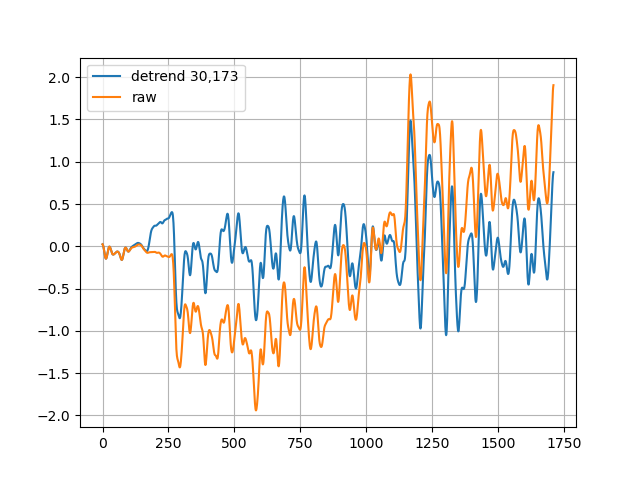

" fft_raw = fft(temp_filled[:,lat,lon])\nfft_diff = fft(diff_detrended[:,lat,lon])\nfft_5 = fft(detrend_4[:,lat,lon])\nfft_10 = fft(detrend_10[:,lat,lon])\nfft_20 = fft(detrend_20[:,lat,lon])\nfft_30 = fft(detrend_30[:,lat,lon])\n\nN = np.shape(temp_filled)[0]\nT = 1/12\nfreqs = fftfreq(N, T)[:N//2]\n\nN_diff = np.shape(temp_filled)[0]-12\nfreqs_diff = fftfreq(N_diff, T)[:N_diff//2]\n\nplt.figure()\nplt.plot(freqs_diff,2.0/N_diff * np.abs(fft_diff[0:N_diff//2]),label = 'diff')\nplt.plot(freqs,2.0/N * np.abs(fft_raw[0:N//2]),label = 'raw')\nplt.plot(freqs,2.0/N * np.abs(fft_5[0:N//2]),label = '4 Y')\nplt.plot(freqs,2.0/N * np.abs(fft_10[0:N//2]),label = '10 Y')\nplt.plot(freqs,2.0/N * np.abs(fft_20[0:N//2]),label = '20 Y')\nplt.plot(freqs,2.0/N * np.abs(fft_30[0:N//2]),label = '30 Y')\n\nmonths = [N//4,N//3,N//2,N,30*12,12,24,48,6,3,4]\nfreq = [12/(i) for i in months]\nlabel = [str(i) for i in months]\nplt.xticks(freq,label,rotation = 90)\nplt.grid(alpha = 0.95)\nplt.legend()\nplt.show(

In [227]:
lon = 250

# SMOOTHED TEMP TO SEE DETREND
plt.figure()
#for i in range(0,60,6):
    #plt.plot(gaussian_filter(temp_filled[:,120+i,lon],6), label = 'raw')
    #plt.plot(gaussian_filter(detrend_30[:,119+i,lon],6)-gaussian_filter(temp_filled[:,119+i,lon],6), label = 'detrend 30,'+str(119+i))

plt.plot(gaussian_filter(detrend_30[:,149,lon],6), label = 'detrend 30,')
plt.plot(gaussian_filter(temp_filled[:,149,lon],6), label = 'raw')
plt.grid(alpha = 0.95)
plt.legend()
plt.show()

# FREQUENCY PLOTS

""" fft_raw = fft(temp_filled[:,lat,lon])
fft_diff = fft(diff_detrended[:,lat,lon])
fft_5 = fft(detrend_4[:,lat,lon])
fft_10 = fft(detrend_10[:,lat,lon])
fft_20 = fft(detrend_20[:,lat,lon])
fft_30 = fft(detrend_30[:,lat,lon])

N = np.shape(temp_filled)[0]
T = 1/12
freqs = fftfreq(N, T)[:N//2]

N_diff = np.shape(temp_filled)[0]-12
freqs_diff = fftfreq(N_diff, T)[:N_diff//2]

plt.figure()
plt.plot(freqs_diff,2.0/N_diff * np.abs(fft_diff[0:N_diff//2]),label = 'diff')
plt.plot(freqs,2.0/N * np.abs(fft_raw[0:N//2]),label = 'raw')
plt.plot(freqs,2.0/N * np.abs(fft_5[0:N//2]),label = '4 Y')
plt.plot(freqs,2.0/N * np.abs(fft_10[0:N//2]),label = '10 Y')
plt.plot(freqs,2.0/N * np.abs(fft_20[0:N//2]),label = '20 Y')
plt.plot(freqs,2.0/N * np.abs(fft_30[0:N//2]),label = '30 Y')

months = [N//4,N//3,N//2,N,30*12,12,24,48,6,3,4]
freq = [12/(i) for i in months]
label = [str(i) for i in months]
plt.xticks(freq,label,rotation = 90)
plt.grid(alpha = 0.95)
plt.legend()
plt.show() """

# CHOOSING DETRENDING
Choosing the detrending of 30 years seems to eliminate the global warming trend, and the seasonality to a satifactory degree, but also retain the larger period varibality, as long as the lags are cut off at 30 years to not retain the small peak at approx 855 months (approx 70 year period) but still follow the spetrtum for larger periods.

# Data resampling
The detrended temperature anomaly data is imported and resampled on the grid used in the VEROS simulation

In [10]:
#detrend_data = np.load('detrended dataframe_tr.npy',allow_pickle=True) # Detrended data
#detrend_data = detrend_30


# The land mask for VEROS is imported and land values (1) are replaced by np.nan and saved in 'landMask.npy'
landMask_0 = np.flipud(np.load('landmask_veros4x4.npy'))
landMask = np.where(landMask_0 == 1, np.nan, 1)
np.save('landMask.npy',landMask) 

s = np.shape(detrend_4)
s_diff = np.shape(diff_detrended)
s_data = np.shape(temp_filled)
t = np.linspace(0,s[0]-1,s[0])
t_diff = np.linspace(0,s_diff[0]-1,s_diff[0])
t_data = np.linspace(0,s_data[0]-1,s_data[0])



lat = np.arange(-89.5,90,1)#Cannot reverse this, so we change sign on y_lat
long = np.arange(-272.5,180-93,1) 

f_4 = RegularGridInterpolator((t,lat, long), detrend_4)
f_10 = RegularGridInterpolator((t,lat, long), detrend_10)
f_20 = RegularGridInterpolator((t,lat, long), detrend_20)
f_30 = RegularGridInterpolator((t,lat, long), detrend_30)
f_data = RegularGridInterpolator((t_data,lat, long), temp_filled)
f_diff = RegularGridInterpolator((t_diff,lat, long), diff_detrended)

x_long = np.array([-272., -268., -264., -260., -256., -252., -248., -244., -239.,
   -236., -232., -228., -224., -220., -216., -212., -208., -204.,
   -200., -196., -192., -188., -184., -180., -176., -172., -168.,
   -164., -160., -156., -152., -148., -144., -139., -136., -132.,
   -128., -124., -120., -116., -112., -108., -104., -100.,  -96.,
    -92.,  -88.,  -84.,  -80.,  -76.,  -72.,  -68.,  -64.,  -60.,
    -56.,  -52.,  -48.,  -44.,  -39.,  -36.,  -32.,  -28.,  -24.,
    -20.,  -16.,  -12.,   -8.,   -4.,    0.,    4.,    8.,   12.,
     16.,   20.,   24.,   28.,   32.,   36.,   40.,   44.,   48.,
     52.,   56.,   60.,   64.,   68.,   72.,   76.,   80.,   84.])
y_lat = -1*np.array([-82.378007, -77.621993, -72.894009, -68.193725, -63.54852 , -58.957109,
   -54.445632, -50.011315, -45.67859 , -41.442792, -37.326328, -33.322406,
   -29.45125 , -25.703867, -22.098298, -18.62342 , -15.295222, -12.100637,
    -9.053834,  -6.139064,  -3.371963,  -0.458193,   2.58861 ,   5.783195,
     9.111392,  12.58627 ,  16.19184 ,  19.939223,  23.810379,  27.814301,
    31.930765,  36.166562,  40.499288,  44.933605,  49.445082,  54.036493,
    58.681698,  63.381982,  68.109966,  72.86598 ])

tt,yt,xt = np.meshgrid(t,y_lat, x_long,indexing = 'ij') 
test_points = np.array([tt.ravel(),yt.ravel(),xt.ravel()]).T

tt_diff,yt,xt = np.meshgrid(t_diff,y_lat, x_long,indexing = 'ij') 
test_points_diff = np.array([tt_diff.ravel(),yt.ravel(),xt.ravel()]).T

tt_data,yt,xt = np.meshgrid(t_data,y_lat, x_long,indexing = 'ij') 
test_points_data = np.array([tt_data.ravel(),yt.ravel(),xt.ravel()]).T

rescaledGrids_4 = f_4(test_points).reshape(s[0], 40,90)
for i in range(np.shape(detrend_4)[0]):
    rescaledGrids_4[i] = np.flipud(rescaledGrids_4[i])


rescaledGrids_10 = f_10(test_points).reshape(s[0], 40,90)
for i in range(np.shape(detrend_10)[0]):
    rescaledGrids_10[i] = np.flipud(rescaledGrids_10[i])


rescaledGrids_20 = f_20(test_points).reshape(s[0], 40,90)
for i in range(np.shape(detrend_20)[0]):
    rescaledGrids_20[i] = np.flipud(rescaledGrids_20[i])


rescaledGrids_30 = f_30(test_points).reshape(s[0], 40,90)
for i in range(np.shape(detrend_4)[0]):
    rescaledGrids_30[i] = np.flipud(rescaledGrids_30[i])


rescaledGrids_diff = f_diff(test_points_diff).reshape(s_diff[0], 40,90)
for i in range(np.shape(diff_detrended)[0]):
    rescaledGrids_diff[i] = np.flipud(rescaledGrids_diff[i])


rescaledGrids_data = f_data(test_points_data).reshape(s_data[0], 40,90)
for i in range(np.shape(temp_filled)[0]):
    rescaledGrids_data[i] = np.flipud(rescaledGrids_data[i])

np.save('rescaledGrids_10.npy', rescaledGrids_10)
#rescaledGrids  = np.load('rescaledGrids.npy')

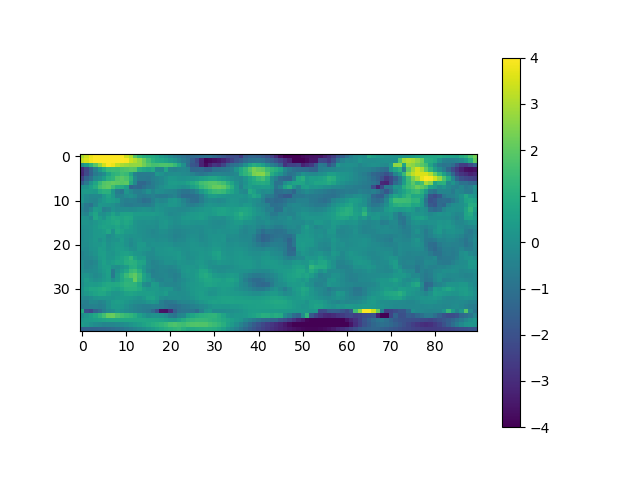

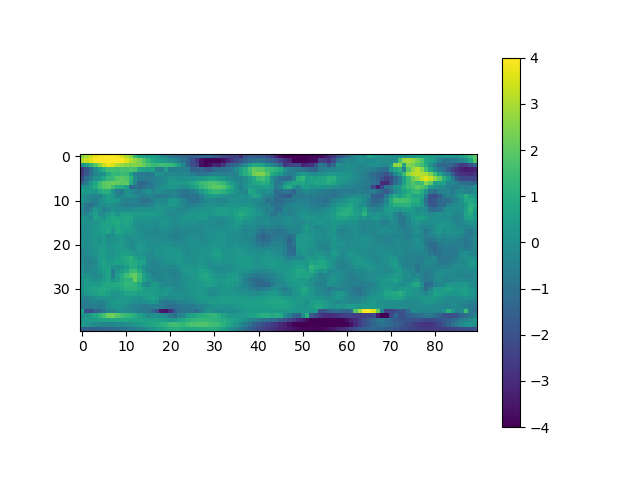

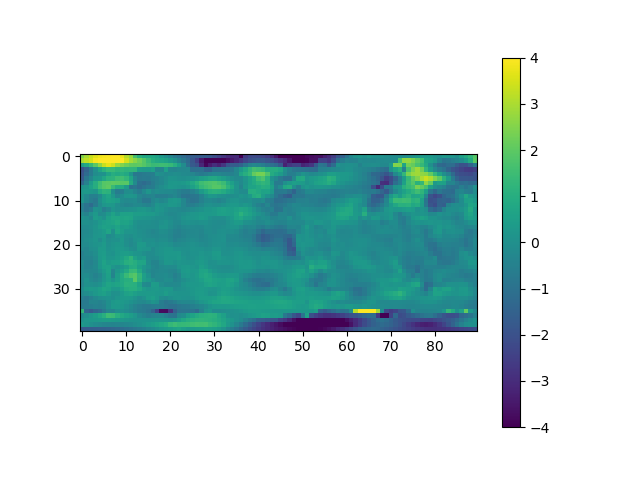

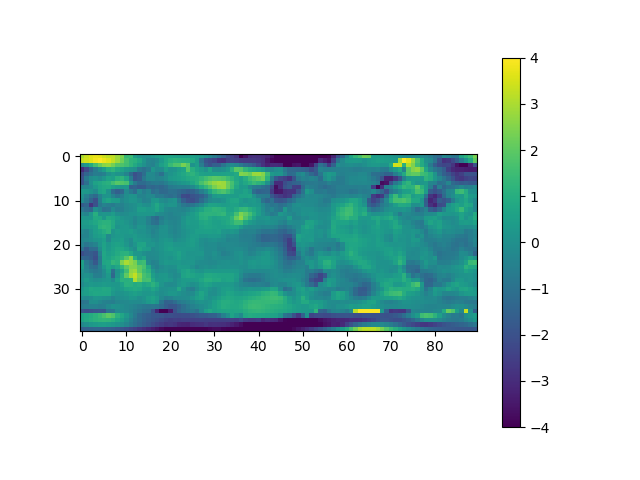

In [112]:
plt.figure()
plt.imshow((rescaledGrids_30[1600]), vmin = -4,vmax = 4)
plt.colorbar()
plt.show()
plt.figure()
plt.imshow((rescaledGrids_20[1600]), vmin = -4,vmax = 4)
plt.colorbar()
plt.show()
plt.figure()
plt.imshow((rescaledGrids_10[1600]), vmin = -4,vmax = 4)
plt.colorbar()
plt.show()

plt.figure()
plt.imshow((rescaledGrids_diff[1600-12]), vmin = -4,vmax = 4)
plt.colorbar()
plt.show()

# SEASONAL CYCLE COMPARISON

In [24]:
def POINT_SEASON_red(grid,lat, lon):
    time = np.shape(grid)[0]
    point = grid[:,lat,lon]
    seasonal_cycle = np.zeros(12)
    for i in range(12):
        seasonal_cycle[i] = np.nanmean(point[i::12])
    if np.isnan(seasonal_cycle).all():
        return [np.nan,np.nan]
    else:
        return [np.abs(max(seasonal_cycle)-min(seasonal_cycle)),np.nanstd(grid[:,lat,lon])/np.nanstd(seasonal_cycle)]

In [25]:
#4,10,20,30,diff,raw
rescaledForcing = np.load('rescaledForcing.npy')*landMask[1:]
ratios_res = np.zeros([6,39,90])
ratios_std = np.zeros([6,39,90])
ratios_model = np.zeros([6,39,90])
ratios_forcing = np.zeros([39,90])
band_res = np.zeros([6,39])
band_std = np.zeros([6,39])
band_model = np.zeros([6,39])
band_forcing = np.zeros(39)
model_vals = [i for i in range(6)]

rescaledGrids_4_l = rescaledGrids_4*landMask
rescaledGrids_10_l = rescaledGrids_10*landMask
rescaledGrids_20_l = rescaledGrids_20*landMask
rescaledGrids_30_l = rescaledGrids_30*landMask
rescaledGrids_diff_l = rescaledGrids_diff*landMask
rescaledGrids_data_l = rescaledGrids_data*landMask

for i in range(39):
    for j in range(90):
        forcing_vals = POINT_SEASON_red(rescaledForcing,i,j)
        model_vals[0] = POINT_SEASON_red((rescaledGrids_4_l)[:,1:,:],i,j)
        model_vals[1] = POINT_SEASON_red((rescaledGrids_10_l)[:,1:,:],i,j)
        model_vals[2] = POINT_SEASON_red((rescaledGrids_20_l)[:,1:,:],i,j)
        model_vals[3] = POINT_SEASON_red((rescaledGrids_30_l)[:,1:,:],i,j)
        model_vals[4] = POINT_SEASON_red((rescaledGrids_diff_l)[:,1:,:],i,j)
        model_vals[5] = POINT_SEASON_red((rescaledGrids_data_l)[:,1:,:],i,j)
        #print(model_vals[0])
        for m in range(6):
            ratios_res[m,i,j] = forcing_vals[0]/model_vals[m][0]
            ratios_std[m,i,j] = model_vals[m][1]
            ratios_model[m,i,j] = model_vals[m][0]
        ratios_forcing[i,j] = forcing_vals[0]  
    for m in range(6):
        band_res[m,i] = np.nanmean(ratios_res[m,i,:])
        band_std[m,i] = np.nanmean(ratios_std[m,i,:])
        band_model[m,i] = np.nanmean(ratios_model[m,i,:])
    band_forcing[i] = np.nanmean(ratios_forcing[i,:])

/var/folders/5k/p5gdyj_n6vgfb8n0ht9rc0sm0000gn/T/ipykernel_96993/895108403.py:6: RuntimeWarning: Mean of empty slice
  seasonal_cycle[i] = np.nanmean(point[i::12])
/var/folders/5k/p5gdyj_n6vgfb8n0ht9rc0sm0000gn/T/ipykernel_96993/3428175423.py:36: RuntimeWarning: Mean of empty slice
  band_res[m,i] = np.nanmean(ratios_res[m,i,:])
/var/folders/5k/p5gdyj_n6vgfb8n0ht9rc0sm0000gn/T/ipykernel_96993/3428175423.py:37: RuntimeWarning: Mean of empty slice
  band_std[m,i] = np.nanmean(ratios_std[m,i,:])
/var/folders/5k/p5gdyj_n6vgfb8n0ht9rc0sm0000gn/T/ipykernel_96993/3428175423.py:38: RuntimeWarning: Mean of empty slice
  band_model[m,i] = np.nanmean(ratios_model[m,i,:])
/var/folders/5k/p5gdyj_n6vgfb8n0ht9rc0sm0000gn/T/ipykernel_96993/3428175423.py:39: RuntimeWarning: Mean of empty slice
  band_forcing[i] = np.nanmean(ratios_forcing[i,:])


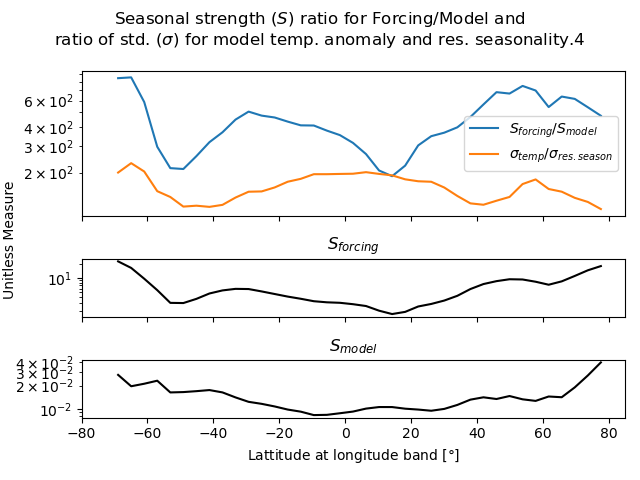

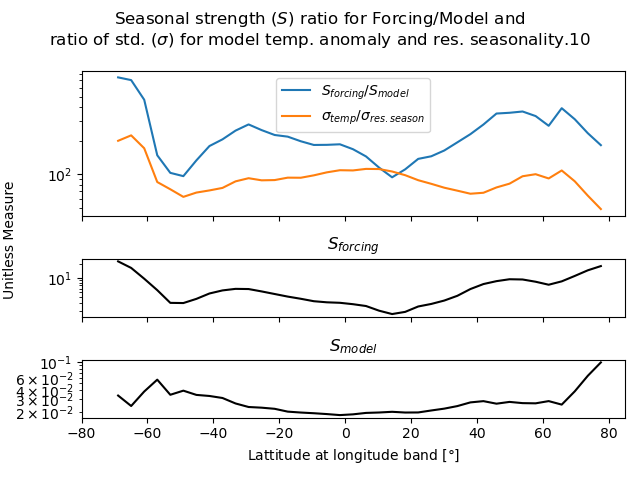

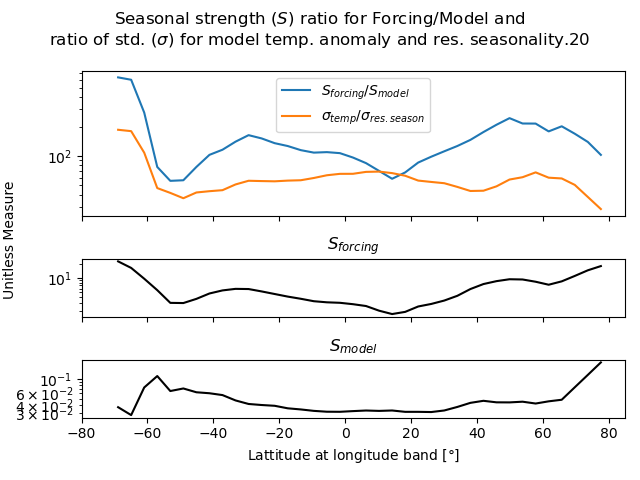

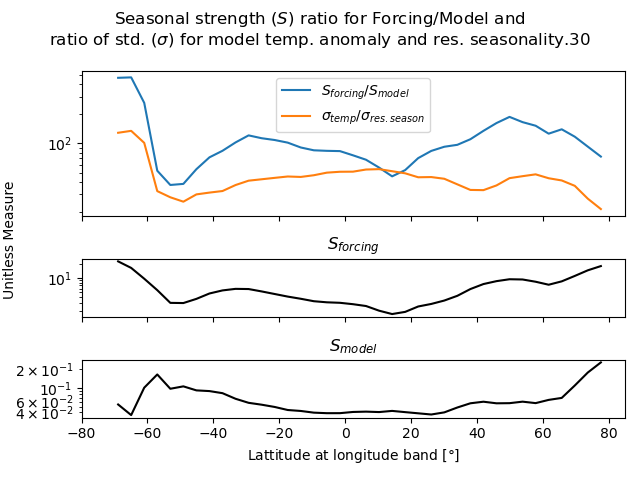

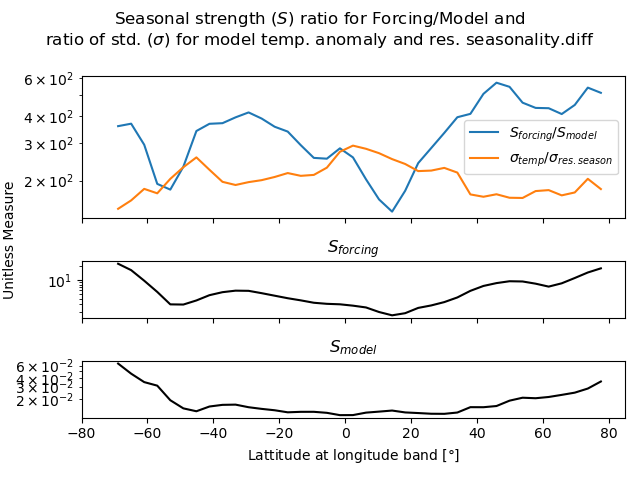

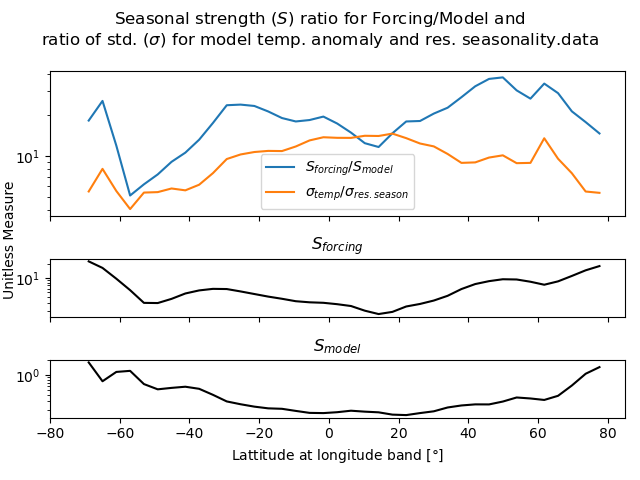

In [26]:
titles = ['4','10','20','30','diff','data']
for i in range(6):
    fig,ax = plt.subplots(3,1,sharex=True, tight_layout = True,gridspec_kw={'height_ratios': [2.5, 1,1]})
    ax[0].semilogy(np.linspace(17.13402-90,167.62-90,39),np.flip(band_res[i]),label = '$S_{forcing}$/$S_{model}$')
    ax[0].semilogy(np.linspace(17.13402-90,167.62-90,39),np.flip(band_std[i]),label = r'$\sigma_{temp}$/$\sigma_{res. season}$')
    ax[1].semilogy(np.linspace(17.13402-90,167.62-90,39),np.flip(band_forcing),label = '$S_{forcing}$',color = 'black')
    ax[2].semilogy(np.linspace(17.13402-90,167.62-90,39),np.flip(band_model[i]),label = '$S_{model}$', color = 'black')
    ax[2].set_xticks(np.arange(10-90,180-90,20))
    #ax[2].set_yticks(np.arange(0.014,0.022,1))
    ax[2].set_xlabel('Lattitude at longitude band [$\degree$]')
    fig.text(0.004, 0.5, 'Unitless Measure', va='center', rotation='vertical')
    fig.suptitle('Seasonal strength ($S$) ratio for Forcing/Model and'
            '\n'
            'ratio of std. ($\sigma$) for model temp. anomaly and res. seasonality.'+ titles[i])
    ax[0].legend()
    ax[1].set_title('$S_{forcing}$')
    ax[2].set_title('$S_{model}$')


# EOFs and PCs
Now that the data has been resampled, we can do the EOF analysis. Here we use the EOFs expressed as covariance and use the narmlized PCs.


In [11]:
solver_re = Eof(rescaledGrids_10*landMask) # The EOFs are calculated after applying the landmask, since we are only interested in the ocean dynamics
eof_re = solver_re.eofs()
pc_re = solver_re.pcs()

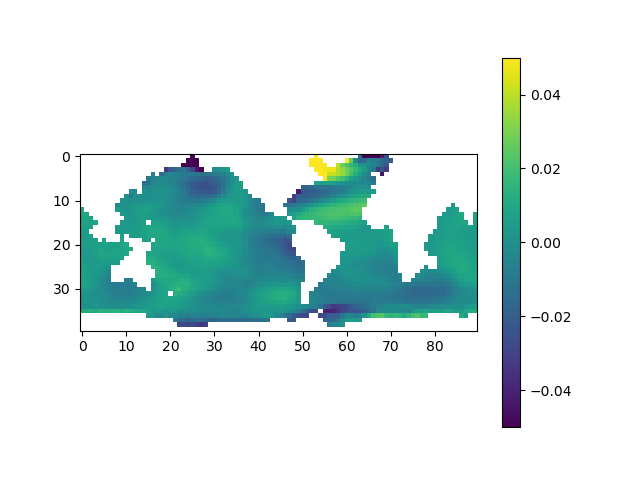

In [17]:
plt.figure()
plt.imshow(eof_re[4],vmin = -0.05,vmax = 0.05)
plt.colorbar()
plt.show()

We show the first few EOFs

As a sanity check we recontruct a grid from the data using the EOFs and PCs and plot the residual.

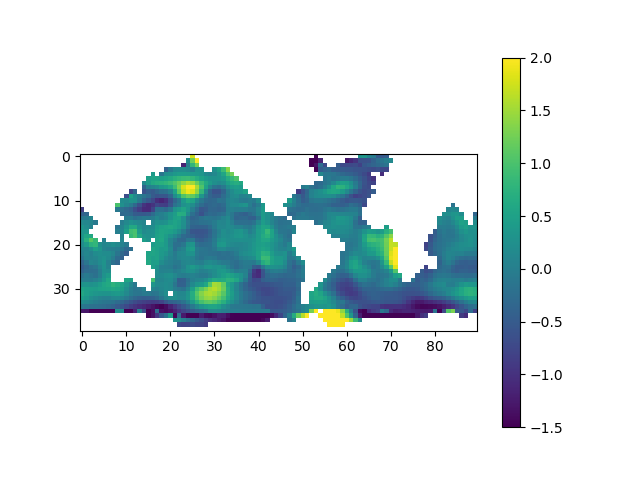

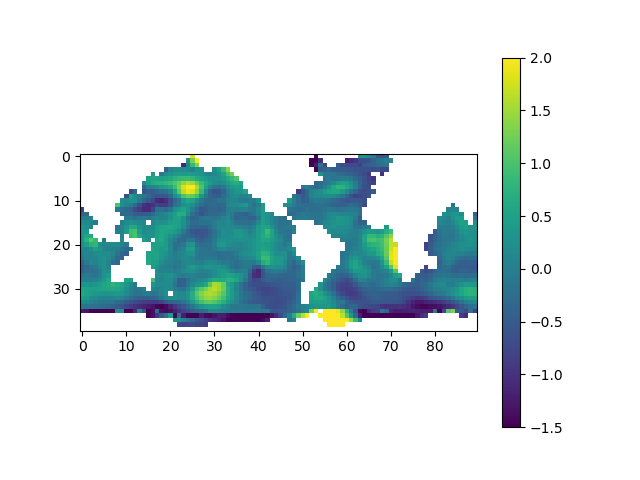

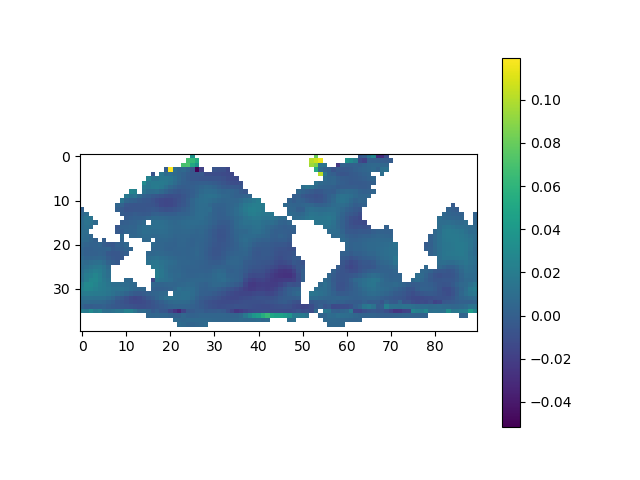

In [18]:
grid0 = np.tensordot(pc_re[1000],eof_re, axes = ([0],[0])) #linear combination of EOFs using PC coefficients
plt.figure()
plt.imshow(grid0,vmin = -1.5,vmax = 2)# PCs and EOFs reproced grid
plt.colorbar()
plt.figure()
plt.imshow(rescaledGrids_10[1000]*landMask,vmin = -1.5,vmax = 2) # True data grid
plt.colorbar()
plt.figure()
plt.imshow(rescaledGrids_10[1000]*landMask-grid0)#Difference
plt.colorbar()

We can estimate the fraction of the variance explained by the number of EOFs used and determine how many EOFs to use in the AR-model, based on some cut-off. A larger cut off leads to more EOFs which is more computationally intesive.

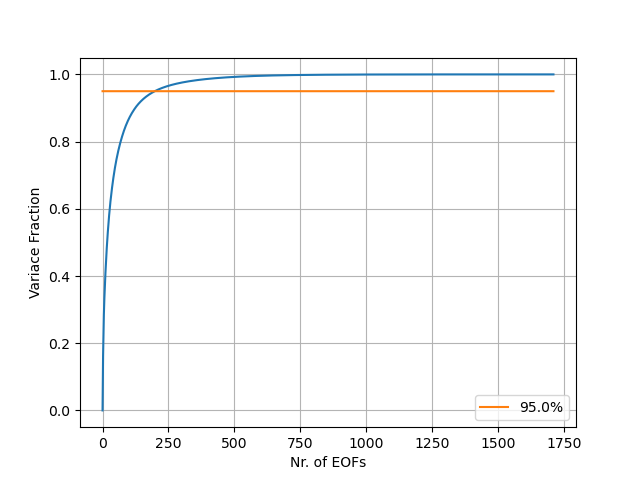

198


In [19]:
varfrac = 0.95

plt.figure()
var_pc_re = solver_re.varianceFraction()
var_pc_re_sum = np.asarray([np.sum(var_pc_re[:i]) for i in range(len(var_pc_re))])
plt.plot(var_pc_re_sum)
plt.xlabel('Nr. of EOFs')
plt.ylabel('Variace Fraction')
plt.grid(alpha = 0.95)
plt.plot(np.ones(np.shape(var_pc_re)[0])*varfrac, label = str(varfrac*100)+'%')
plt.legend()
plt.show()

def pick_pc_re(exp_var):
    print(np.argmin(np.abs(var_pc_re_sum-exp_var)))
    return np.argmin(np.abs(var_pc_re_sum-exp_var))


nr_eofs = int(pick_pc_re(varfrac)) # Print the number of EOFs needed to have a var. frac. of 90%

Now we can determine the lag of each AR model for each PC. This is done by computing the Partial Autocorrelation Function for each index in the PCs.
The choice of $\alpha$ seems importan, since if too low, we introduce autocorrelations that are not present in the data, at large lags, but we also do not want to be too stirngent, since we maybe not have enough data to be very certain that the ac's that should be present are captured. For $\alpha = 0.01$ we capture very large ac's not present. For $\alpha = 0.01$

In [20]:
lags = 20*12
pacf_lag_re = np.zeros(nr_eofs)
acf_lag_re = np.zeros(nr_eofs)
thresholdList_re = np.zeros([nr_eofs, lags+1])
confList_re = np.zeros(nr_eofs)
for i in range(nr_eofs):
    p_re, conf_re = pacf(pc_re[:,i],alpha = 0.001, nlags = lags, method = 'ywm') # the pacf is computed for each time series
    conf_set_re = np.asarray([conf_re[j,1]-p_re[j] for j in range(lags+1)]) #The confidence interval is set
    pacf_lag_re[i] = np.amax(np.nonzero(np.where(np.abs(p_re)>conf_set_re,1,0))) # masking the pacf with 1 or 0 when inside or outside of confidence interval
    thresholdList_re[i,:] = np.abs(p_re) 
    confList_re[i] = conf_set_re[1]

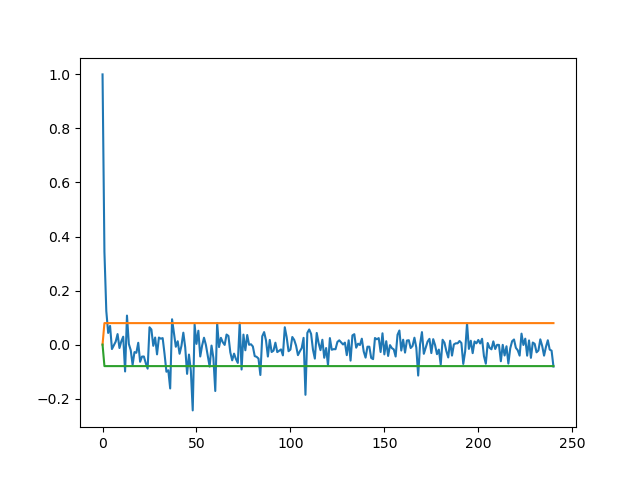

In [21]:
p_re, conf_re = pacf(pc_re[:,1],alpha = 0.001, nlags = lags, method = 'ywm') 
conf_set_re0 = np.asarray([conf_re[j,1]-p_re[j] for j in range(lags+1)])
conf_set_re1 = np.asarray([conf_re[j,0]-p_re[j] for j in range(lags+1)])
plt.figure()
plt.plot(p_re)
plt.plot(conf_set_re0)
plt.plot(conf_set_re1)
plt.show()


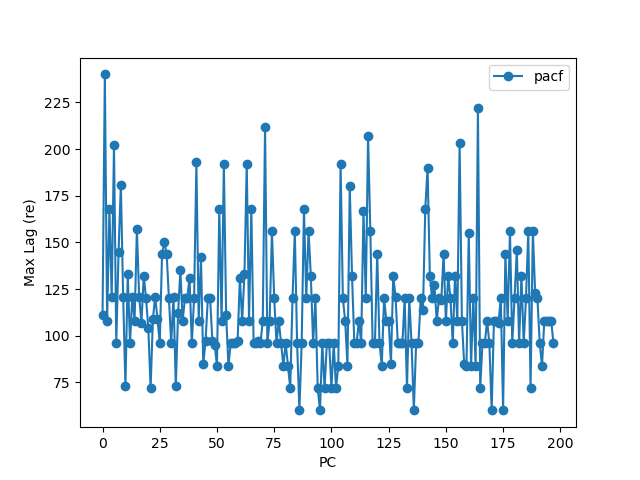

In [22]:
#plot the lag estimated for each PC
plt.figure()
plt.plot(pacf_lag_re, '-o',label = 'pacf')
plt.xlabel('PC')
plt.ylabel('Max Lag (re)')
plt.legend()
plt.show()

The lag for each PC is saved in the file 'Lags.npy'

In [23]:
print(pacf_lag_re)
np.save('Lags.npy', pacf_lag_re)
print(np.unique(pacf_lag_re))

[111. 240. 108. 168. 121. 202.  96. 145. 181. 121.  73. 133.  96. 121.
 108. 157. 121. 107. 132. 120. 104.  72. 109. 121. 109.  96. 144. 150.
 144. 120.  96. 121.  73. 112. 135. 108. 120. 120. 131.  96. 120. 193.
 108. 142.  85.  97. 120. 120.  97.  95.  84. 168. 108. 192. 111.  84.
  96.  96.  96.  97. 131. 108. 133. 192. 108. 168.  96.  96.  97.  96.
 108. 212.  96. 108. 156. 120.  96. 108.  96.  84.  96.  84.  72. 120.
 156.  96.  60.  96. 168. 120. 156. 132.  96. 120.  72.  60.  96.  72.
  96.  96.  72.  96.  72.  84. 192. 120. 108.  84. 180. 132.  96.  96.
 108.  96. 167. 120. 207. 156.  96.  96. 144.  96.  84. 120. 108. 108.
  85. 132. 121.  96.  96.  96. 120.  72. 120.  96.  60.  96.  96. 120.
 114. 168. 190. 132. 120. 127. 108. 120. 119. 144. 108. 132. 120.  96.
 132. 108. 203. 108.  85.  84. 155.  84. 120.  84. 222.  72.  96.  96.
 108.  96.  60. 108. 108. 107. 120.  60. 144. 108. 156.  96. 120. 146.
  96. 132.  96. 120. 156.  72. 156. 123. 120.  96.  84. 108. 108. 108.
 108. 

The EOFs na d PCs are now saved in order

In [24]:
np.save('EOFs_new.npy',eof_re[:nr_eofs])
np.save('PCs_new.npy',pc_re[:,:nr_eofs])

# Yule-Walker
We use the Yule-Walker method to estimate the AR-model for each PC given the lag

In [25]:
l_m = int(np.amax(pacf_lag_re)) # Find the maximal lag used and make an [maxLag x Nr_eofs] array - this seems faster than treating Nr_eofs arrays individually
rho, sig= np.zeros([nr_eofs,l_m]), np.zeros(nr_eofs)  
for i in range(nr_eofs): # for each eof/PC-index we fit an AR(n)-model to the time series
    rho[i,:int(pacf_lag_re[i])], sig[i] = yule_walker(pc_re[:,i],order = int(pacf_lag_re[i]))

#The coefficients and sigma for the white noise are saved below.
np.save('yw_rho_new.npy', rho)
np.save('yw_sigma_new.npy', sig)

# Running Noise Model
We set up the noise field generator with an initialization and a step function.
This is essentially the same noise as on the cluster in the setup_5y_new directory 

In [26]:
def initialize():
    pc_lag_re = np.zeros([nr_eofs,l_m])
    pc_lag_re[:,0] = np.zeros_like(nr_eofs)
    pc_series_re = np.zeros(nr_eofs)

    grid = np.zeros([2,40,90])
    for p in range(nr_eofs):
        lag = int(pacf_lag_re[p])
        pc_lag_re[p,l_m-1] = np.dot(pc_lag_re[p,:lag],rho[p,:lag])+np.random.normal(0,sig[p]) 
        pc_lag_re[p,:] = np.roll(pc_lag_re[p,:],1)
    pc_series_re = pc_lag_re[:,0]
    #grid[1] = np.tensordot(pc_series_re,eof_re[:nr_eofs], axes = ([0],[0]))
    grid[1] = np.tensordot(pc_series_re,eof_re[:nr_eofs], axes = ([0],[0]))
    
    return grid, pc_lag_re

def step(grid, pc_lag_re):
    grid = np.flip(grid,axis = 0)
    for p in range(nr_eofs):
        lag = int(pacf_lag_re[p])
        pc_lag_re[p,l_m-1] = np.dot(pc_lag_re[p,:lag],rho[p,:lag])+np.random.normal(0,sig[p]) 
        pc_lag_re[p,:] = np.roll(pc_lag_re[p,:],1)
    pc_series_re = pc_lag_re[:,0] 
    #grid[1] = np.tensordot(pc_series_re, eof_re[:nr_eofs], axes = ([0],[0]))
    grid[1] = np.tensordot(pc_series_re,eof_re[:nr_eofs], axes = ([0],[0]))
    return grid, pc_lag_re

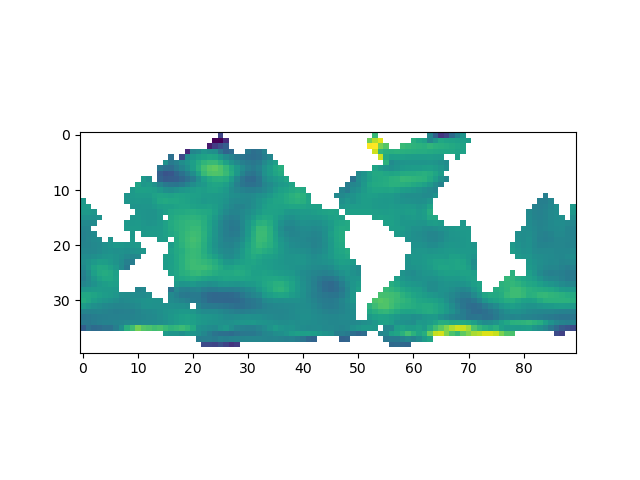

In [27]:
grid, pc = initialize() #initialize the grid
plt.figure()
plt.imshow(grid[1])
plt.show()

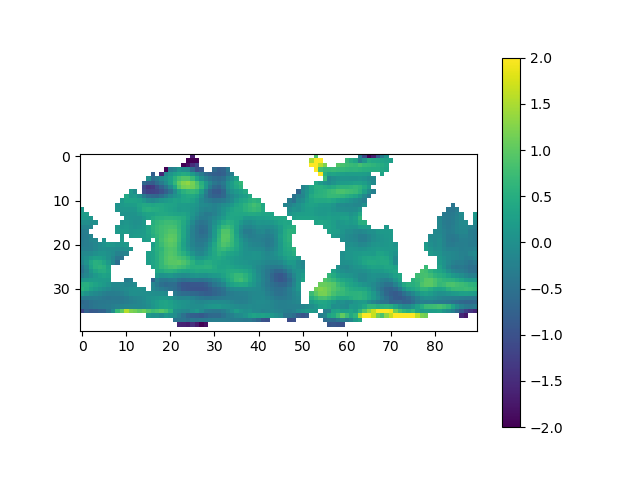

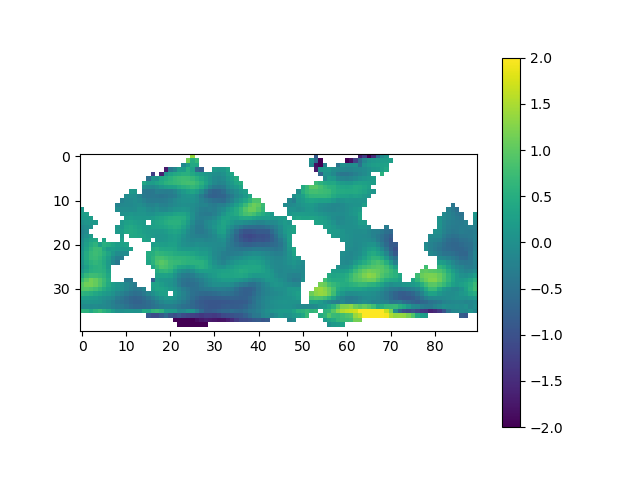

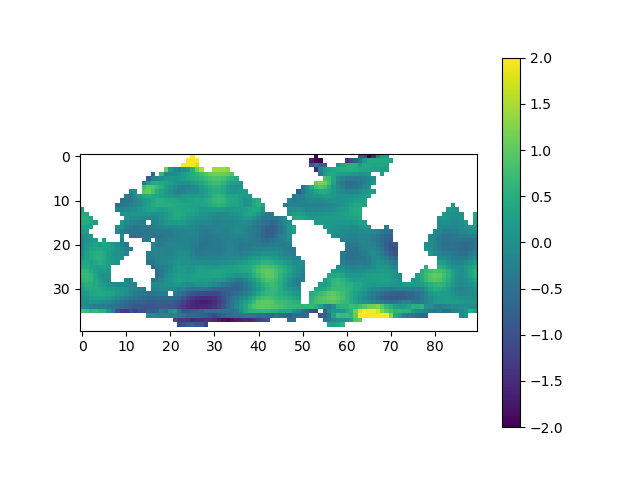

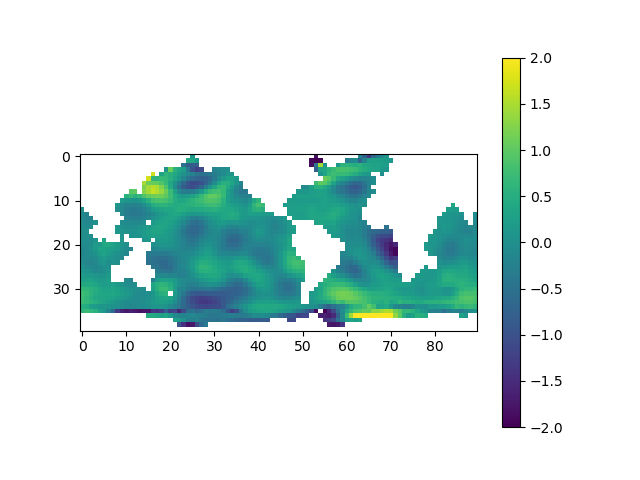

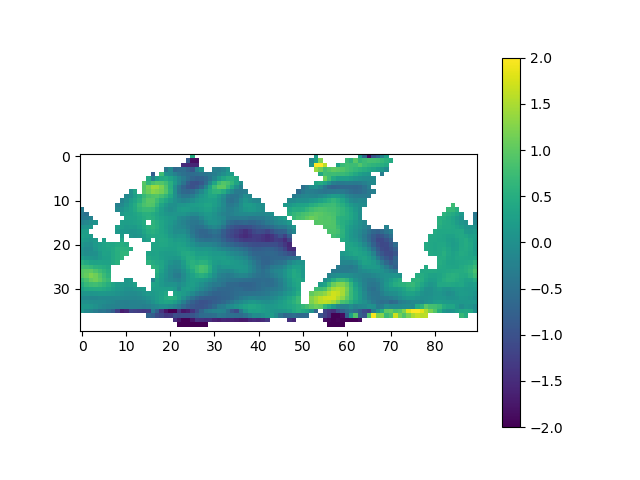

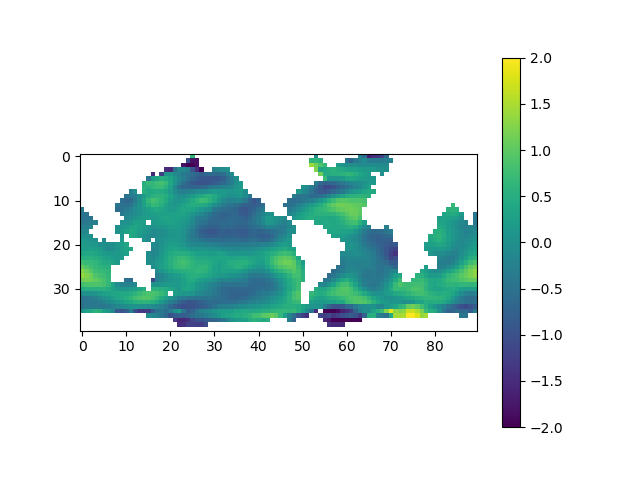

/var/folders/5k/p5gdyj_n6vgfb8n0ht9rc0sm0000gn/T/ipykernel_578/2707631010.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


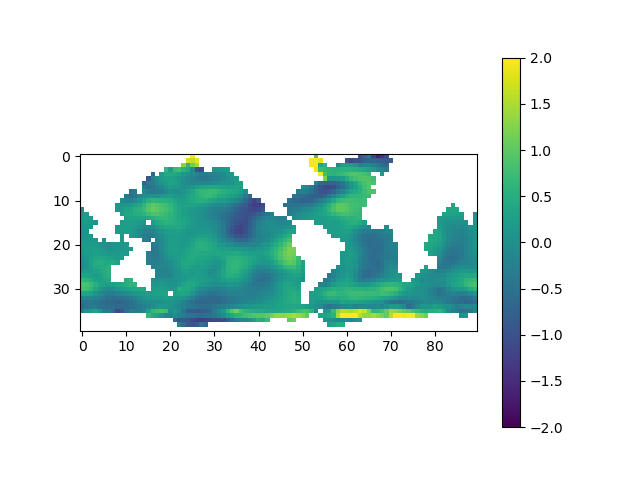

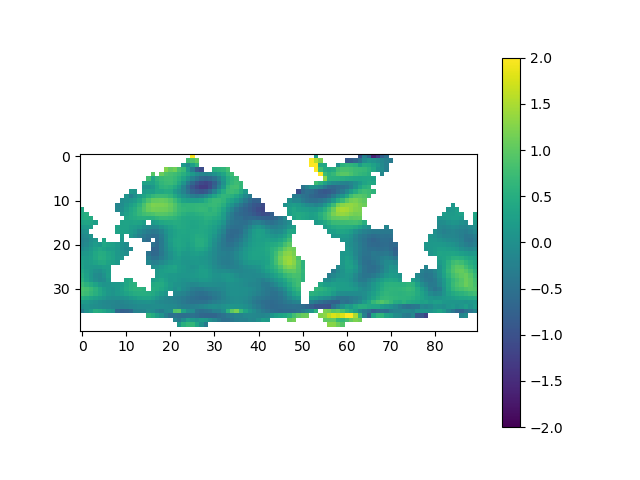

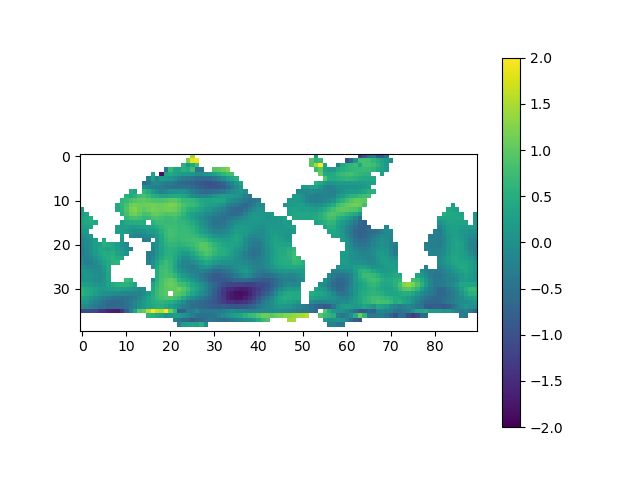

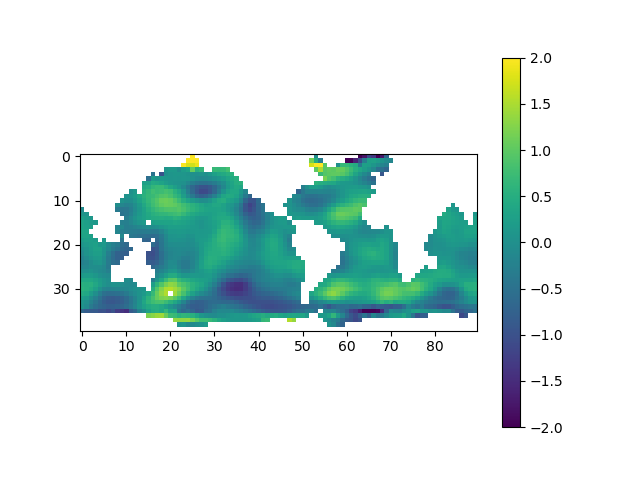

In [28]:
for i in range(10): # run 10 steps and show the grids
    grid, pc = step(grid,pc)
    plt.figure()
    plt.imshow(grid[0],vmin=-2,vmax = 2)
    plt.colorbar()
    plt.show()


# Test
The time it takes to simulate 100 and 1000 years of noise at a monthly resolution is estimated. On my PC this took approx. 5 min. to run.

In [29]:
def fortime100(grid,pc):
    for i in range(12*100):
        step(grid,pc)

def fortime1000(grid,pc):
    for i in range(12*1000):
        step(grid,pc)
%timeit fortime100(grid, pc) # time to simulate 100 years of noise
#%timeit fortime1000(grid, pc) # time to simulate 1000 years of noise

3.5 s ± 265 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Analysis
We determine the NAO, AMO and ENSO from the data and the simulation and compare the results

In [30]:
grids = np.empty([12*1000,40,90])
grid, pc = initialize() 
for i in range(12*1000):
    grid, pc = step(grid,pc)
    grids[i,:,:] = grid[0]

(1711,) (855,)


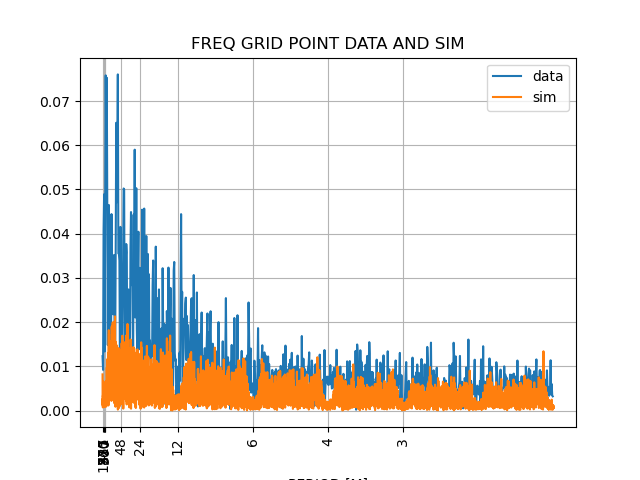

In [34]:
# WE SEE LOWER POWER AT LARGE PERIODS SINCE THESE ARE FILTERED OUT BY CHOOSING LARGE ALPHA FOR PACF
lat = 20
lon = 60


#fr_sim = welch(np.nanmean(grids[1000:1000+1750,:15,:], axis = (1,2)),fs)
fft_data = fft((rescaledGrids_30*landMask)[:,lat,lon])
fft_sim = fft(grids[:,lat,lon])




N = np.shape(rescaledGrids_30)[0]
T = 1/12
freq_data = fftfreq(N, T)[:N//2]

N_sim = np.shape(grids)[0]
freq_sim = fftfreq(N_sim, T)[:N_sim//2]

print(np.shape(fft_data), np.shape(freq_data))

plt.figure()
plt.plot(freq_data,2.0/N * np.abs(fft_data[:N//2]),label = 'data')
plt.plot(freq_sim,2.0/N_sim * np.abs(fft_sim[:N_sim//2]),label = 'sim')


plt.title('FREQ GRID POINT DATA AND SIM')
plt.xlabel('PERIOD [M]')
months = [N//4,N//3,N//2,N,30*12,12,24,48,6,3,4]
freq = [12/(i) for i in months]
label = [str(i) for i in months]
plt.xticks(freq,label,rotation = 90)
plt.grid(alpha = 0.95)
plt.legend()
plt.show()



(1711,) (855,)


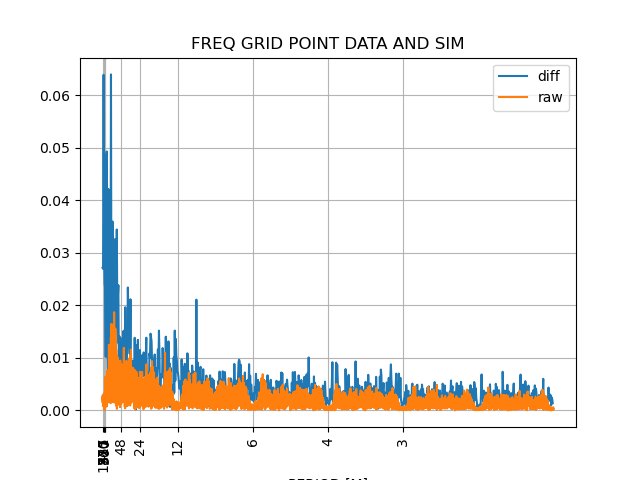

In [35]:
fft_data = fft(np.nanmean((rescaledGrids_30*landMask)[:,:15,:],axis = (1,2)))
fft_sim = fft(np.nanmean(grids[:,:15,:],axis = (1,2)))


N = np.shape(rescaledGrids_30)[0]
T = 1/12
freq_data = fftfreq(N, T)[:N//2]

N_sim = np.shape(grids)[0]
freq_sim = fftfreq(N_sim, T)[:N_sim//2]

print(np.shape(fft_data), np.shape(freq_data))

plt.figure()
plt.plot(freq_data,2.0/N * np.abs(fft_data[:N//2]),label = 'diff')
plt.plot(freq_sim,2.0/N_sim * np.abs(fft_sim[:N_sim//2]),label = 'raw')


plt.title('FREQ GRID POINT DATA AND SIM')
plt.xlabel('PERIOD [M]')
months = [N//4,N//3,N//2,N,30*12,12,24,48,6,3,4]
freq = [12/(i) for i in months]
label = [str(i) for i in months]
plt.xticks(freq,label,rotation = 90)
plt.grid(alpha = 0.95)
plt.legend()
plt.show()

(1711,) (855,)


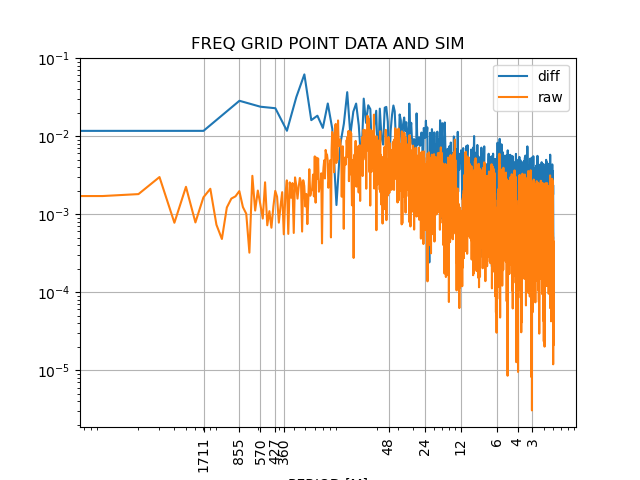

In [36]:
fft_data = fft(np.nanmean((rescaledGrids_30*landMask)[:,:,:],axis = (1,2)))
fft_sim = fft(np.nanmean(grids[:,:,:],axis = (1,2)))


N = np.shape(rescaledGrids_30)[0]
T = 1/12
freq_data = fftfreq(N, T)[:N//2]

N_sim = np.shape(grids)[0]
freq_sim = fftfreq(N_sim, T)[:N_sim//2]

print(np.shape(fft_data), np.shape(freq_data))

plt.figure()
plt.loglog(freq_data,2.0/N * np.abs(fft_data[:N//2]),label = 'diff')
plt.loglog(freq_sim,2.0/N_sim * np.abs(fft_sim[:N_sim//2]),label = 'raw')


plt.title('FREQ GRID POINT DATA AND SIM')
plt.xlabel('PERIOD [M]')
months = [N//4,N//3,N//2,N,30*12,12,24,48,6,3,4]
freq = [12/(i) for i in months]
label = [str(i) for i in months]
plt.xticks(freq,label,rotation = 90)
plt.grid(alpha = 0.95)
plt.legend()
plt.show()

In [37]:
def NAO(grids):
    NAO_eof_solver = Eof((grids)[:,0:14,45:45+25])
    NAO_eof = NAO_eof_solver.eofs(neofs=1)
    NAO_index = NAO_eof_solver.pcs(npcs=1)
    return NAO_index, NAO_eof

def ENSO(grids):  
    ONI = np.empty(np.shape(grids)[0]-1)
    for i in range(np.shape(grids)[0]-1) : 
        ONI[i] = np.nanmean(grids[1+i:i+2,10:25,20:50])#3 mo rolling average
    #sol_EN= Eof(grid[:,10:25,20:50])#EOF over slightly bigger area
    #c_EN = sol_EN.pcs(pcscaling = 1, npcs = 1)
    #EN_eof = sol_EN.eofsAsCorrelation(neofs = 2)
    
    full_EN= Eof(grids[:,10:25,20:50])
    EOF = full_EN.eofs(neofs = 1)
    #for i in range(20):
        #EOF[i] = landmask(EOF[i])
    return ONI, EOF

def AMO(grids):
    time = np.shape(grids)[0]
    amo = np.zeros(time)
    for j in range(time):
        glob_mean = np.nanmean(grids[j])
        amo[j] = np.nanmean(grids[j,5:15,47:45+20])-glob_mean
    return uniform_filter1d(amo,120)


In [38]:
NAO_index_sim, NAO_sim = NAO(grids)
NAO_index_data, NAO_data = NAO(rescaledGrids_10*landMask)

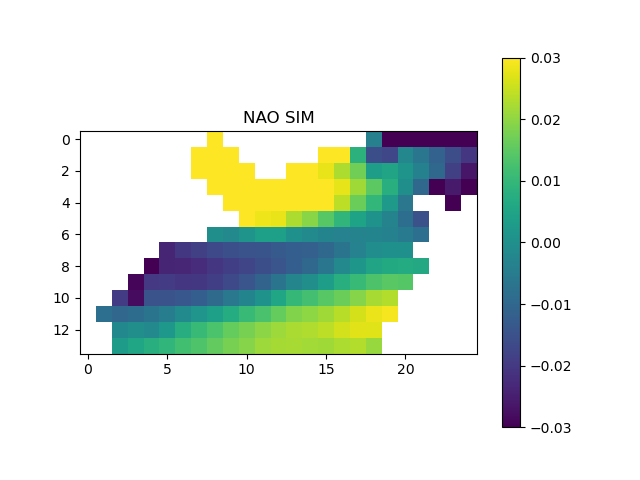

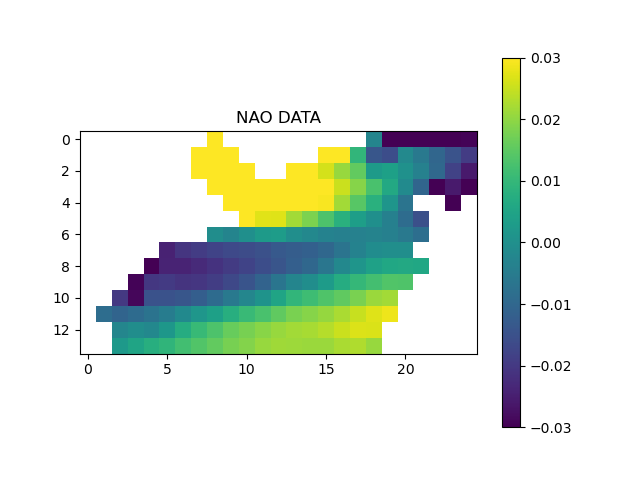

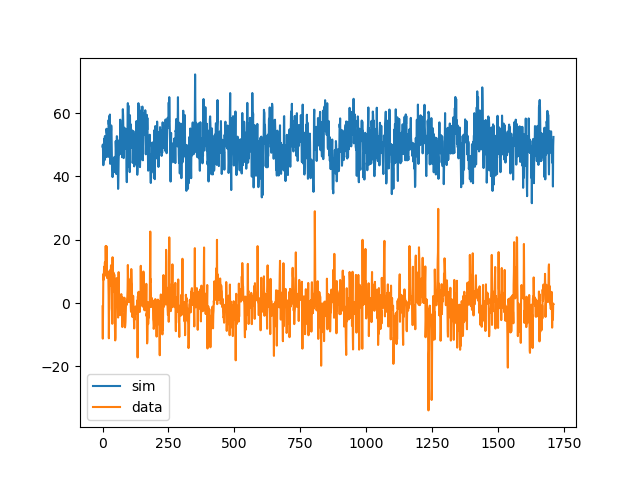

5.775834422386853 5.727605080769533


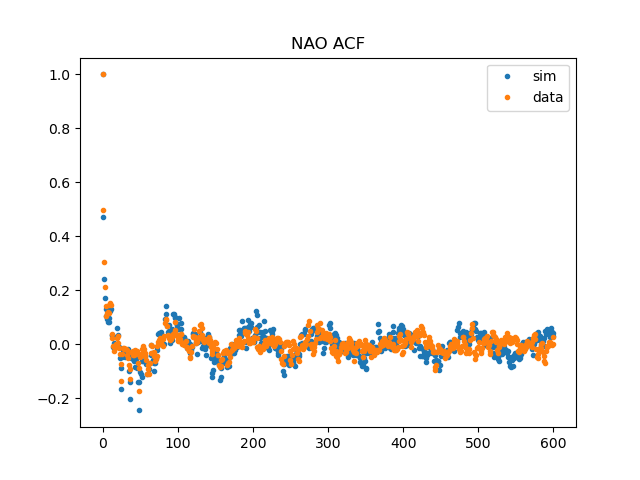

In [47]:
plt.figure()
plt.imshow(NAO_sim[0],vmin = -0.03,vmax=0.03)
plt.colorbar()
plt.title('NAO SIM')
plt.show()

plt.figure()
plt.imshow(NAO_data[0],vmin = -0.03,vmax=0.03)
plt.colorbar()
plt.title('NAO DATA')
plt.show()

plt.figure()
plt.plot(50+NAO_index_sim[:np.shape(NAO_index_data)[0]],label = 'sim')
plt.plot(NAO_index_data,label = 'data')
plt.legend()
plt.show()

print(np.std(NAO_index_data),np.std(NAO_index_sim))


nao_acf_sim= acf(NAO_index_sim[:np.shape(NAO_index_data)[0]], nlags=50*12)
nao_acf_data = acf(NAO_index_data, nlags = 50*12)
plt.figure()
plt.title('NAO ACF')
plt.plot(nao_acf_sim,'.',label = 'sim')
plt.plot(nao_acf_data,'.', label = 'data')
plt.legend()
plt.show()

In [40]:
ENSO_index_sim, ENSO_sim = ENSO(grids)
ENSO_index_data, ENSO_data = ENSO(rescaledGrids_10*landMask)

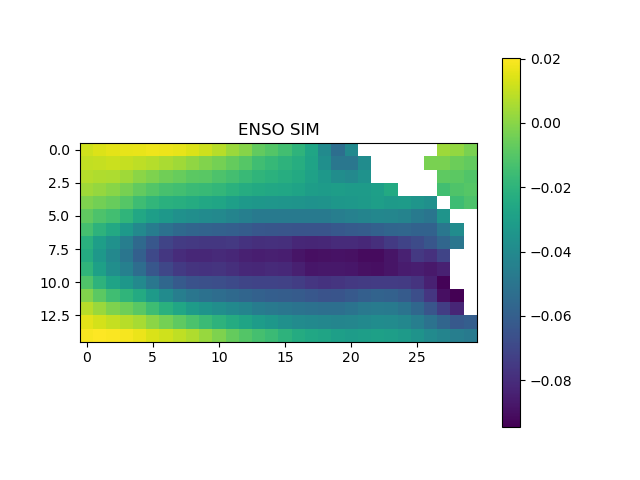

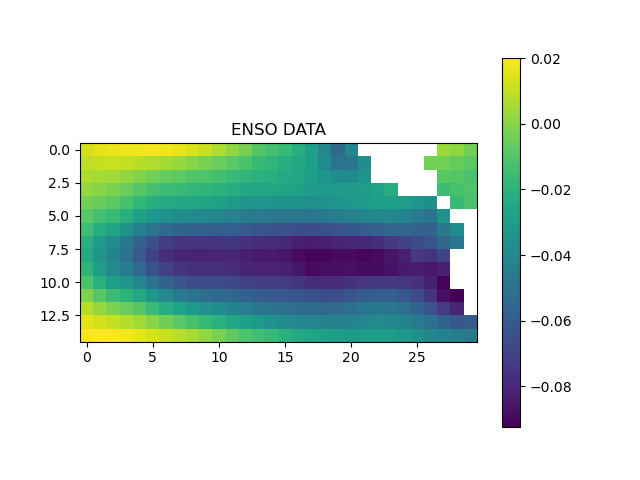

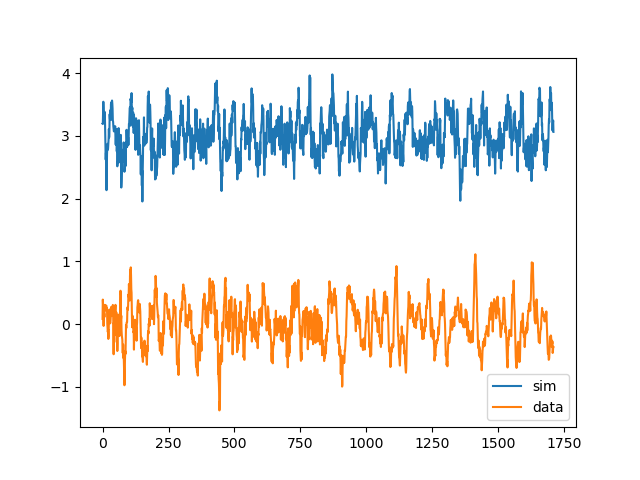

0.34165853012834035 0.35146159528572585


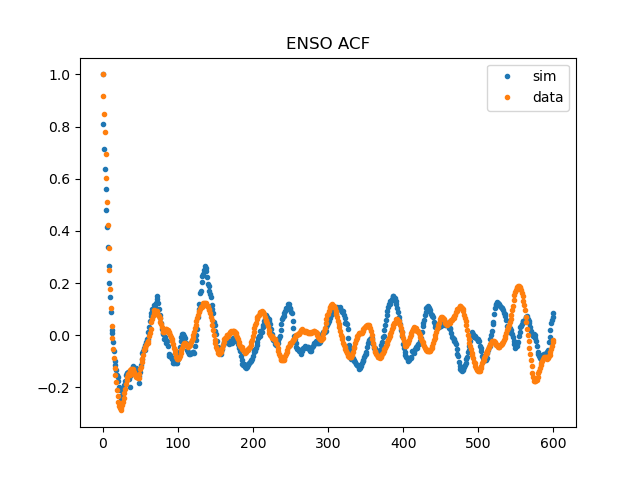

In [41]:
plt.figure()
plt.imshow(ENSO_sim[0])
plt.colorbar()
plt.title('ENSO SIM')
plt.show()

plt.figure()
plt.imshow(ENSO_data[0])
plt.colorbar()
plt.title('ENSO DATA')
plt.show()

plt.figure()
plt.plot(3+ENSO_index_sim[:np.shape(ENSO_index_data)[0]],label = 'sim')
plt.plot(ENSO_index_data,label = 'data')
plt.legend()
plt.show()

print(np.std(ENSO_index_data),np.std(ENSO_index_sim))

enso_acf_sim= acf(ENSO_index_sim[:np.shape(ENSO_index_data)[0]], nlags=50*12)
enso_acf_data= acf(ENSO_index_data, nlags = 50*12)
plt.figure()
plt.title('ENSO ACF')
plt.plot(enso_acf_sim,'.',label = 'sim')
plt.plot(enso_acf_data,'.', label = 'data')
plt.legend()
plt.show()



In [42]:
AMO_sim = AMO(grids)
AMO_data = AMO(rescaledGrids_10*landMask)

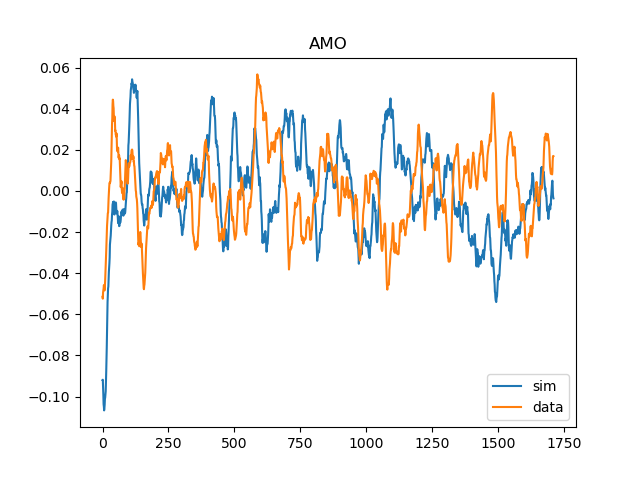

In [43]:
plt.figure()
plt.plot(AMO_sim[:np.shape(AMO_data)[0]],label = 'sim')
plt.plot(AMO_data,label = 'data')
plt.title('AMO')
plt.legend()
np.std(AMO_data),np.std(AMO_sim)
plt.show()

In [44]:
def freq_find_return(time_series):
    freq_plot = plt.psd(time_series,window = mlab.window_none,NFFT = 2**(int(np.floor(len(time_series)/2)-1).bit_length()), noverlap = 2**(int(np.floor(len(time_series)/8)-1).bit_length()))
    return [freq_plot[1],freq_plot[0]]
def fit_func(x,alpha,beta):
    return alpha*(1/(x**beta))
def fit_func_lin(x,alpha,beta):
    return alpha+x*beta

def color(freqs0,freqs1,freq0Name, freq1Name, title):
    
    
    pars0, cov0 = curve_fit(f= fit_func_lin,xdata = np.log10(freqs0[0][1:]),
                         ydata = np.log10(freqs0[1][1:]), p0 = [5,1]) 
    
    plt.figure(figsize = (8,4))
    plt.loglog(*freqs0,label = freq0Name + ' spectrum')
    plt.loglog(*freqs1, label = freq1Name + ' spectrum')
    
    
    
    pars1, cov1 = curve_fit(f= fit_func_lin,xdata = np.log10(freqs1[0][1:]),
                     ydata = np.log10(freqs1[1][1:]), p0 = [5,1]) 
    

    plt.loglog(10**np.linspace(-3,0,1000), 
       fit_func(10**np.linspace(-3,0,1000),10**pars0[0], -pars0[1]),color = 'blue',label = freq0Name +r' fit: $\beta$ = '+str(round(-pars0[1],3)))
    
    plt.loglog(10**np.linspace(-3,0,1000), 
           fit_func(10**np.linspace(-3,0,1000),10**pars1[0], -pars1[1]), color = 'yellow',label = freq1Name +r' fit: $\beta$ = '+str(round(-pars1[1],3)))
    plt.title(title + r' spectrum fit to power law $f^{-\beta}$')
    plt.legend()
    plt.show()
    #print(10**pars0[0],-pars0[1])
    #print(10**pars1[0],-pars1[1])
    #plt.savefig(title+'_spectrum_fit', dpi = 400)
    return pars0,pars1

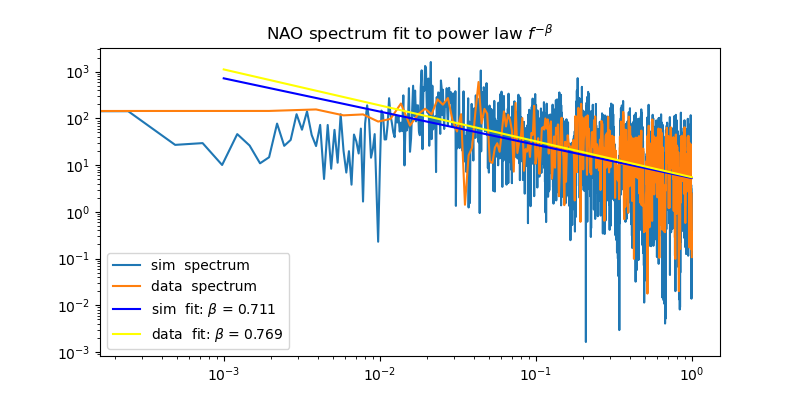

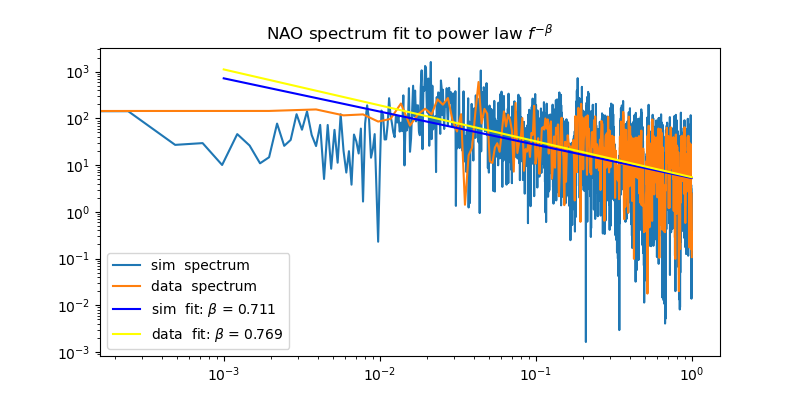

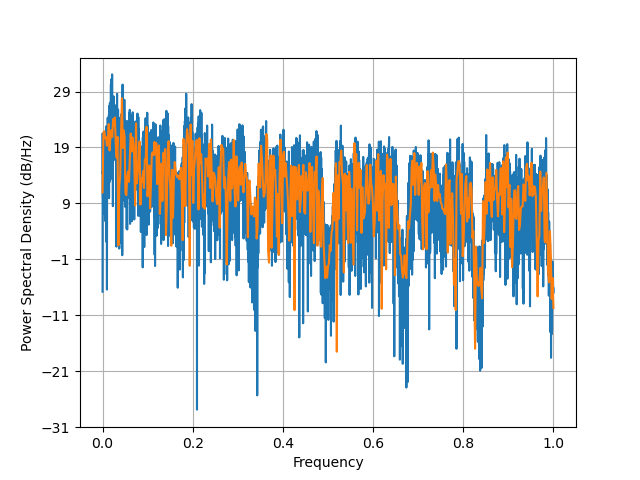

In [45]:
plt.figure()
color(freq_find_return(NAO_index_sim.T[0]),freq_find_return(NAO_index_data.T[0]),'sim ','data ', 'NAO')
plt.show()

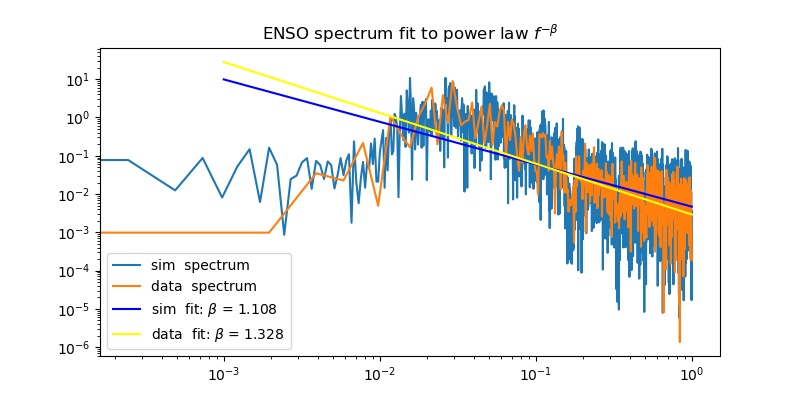

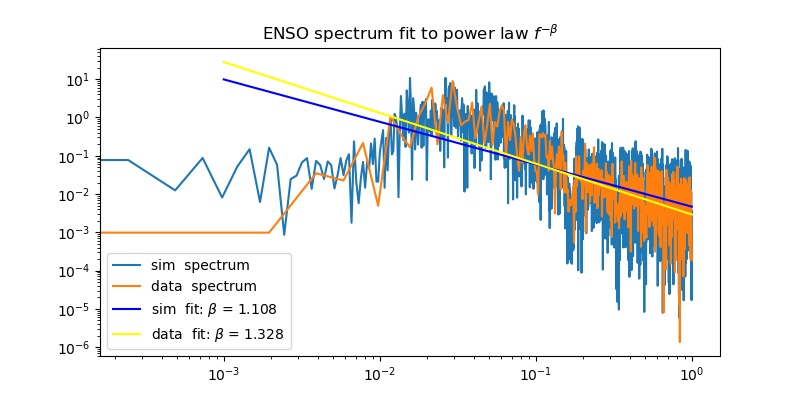

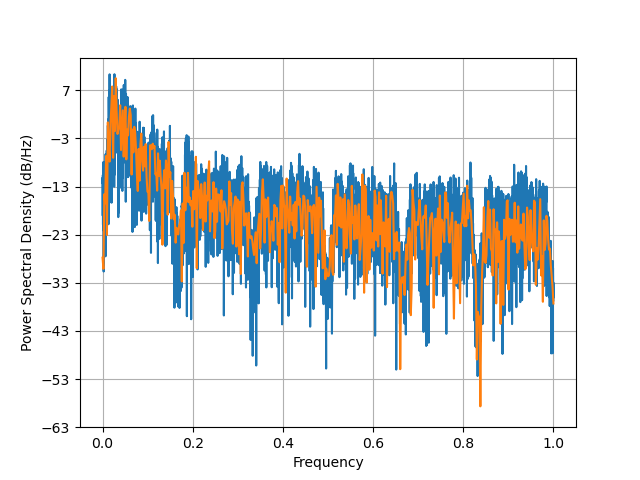

In [46]:
plt.figure()
color(freq_find_return(ENSO_index_sim.T),freq_find_return(ENSO_index_data.T),'sim ','data ', 'ENSO')
plt.show()


In [146]:
time = np.linspace(0,np.shape(rescaledGrids_30)[0],np.shape(rescaledGrids_30)[0])
fit_30 = np.polyfit(time[1000:-5*12],np.nanmean(detrend_30[1000:-5*12],axis = (1,2)),1,cov = True)
fit_20 = np.polyfit(time[1000:],np.nanmean(detrend_20[1000:],axis = (1,2)),1,cov = True)
fit_10 = np.polyfit(time[1000:],np.nanmean(detrend_10[1000:],axis = (1,2)),1,cov = True)
fit_4 = np.polyfit(time[1000:],np.nanmean(detrend_4[1000:],axis = (1,2)),1,cov = True)
fit_raw = np.polyfit(time[1000:],np.nanmean(temp_filled[1000:],axis = (1,2)),1,cov = True)


In [147]:
print(str(fit_30[0][0])+' pm '+ str(np.sqrt(fit_30[1][0,0])))
print(str(fit_20[0][0])+' pm '+ str(np.sqrt(fit_20[1][0,0])))
print(str(fit_10[0][0])+' pm '+ str(np.sqrt(fit_10[1][0,0])))
print(str(fit_4[0][0])+' pm '+ str(np.sqrt(fit_4[1][0,0])))
print(str(fit_raw[0][0])+' pm '+ str(np.sqrt(fit_raw[1][0,0])))

0.0002553373832533676 pm 5.212048688985636e-05
0.00015206335586836152 pm 4.462705531462002e-05
4.4793753180028826e-05 pm 4.328172395805299e-05
4.911352349751426e-06 pm 3.954175298322463e-05
0.0019313129762888528 pm 4.8301402330816067e-05


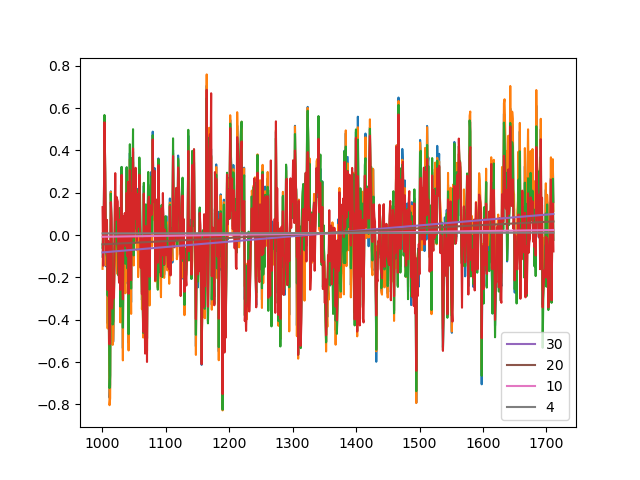

In [158]:
plt.figure()

plt.plot(time[1000:], np.nanmean(detrend_20[1000:],axis = (1,2)))
plt.plot(time[1000:], np.nanmean(detrend_30[1000:],axis = (1,2)))
plt.plot(time[1000:], np.nanmean(detrend_10[1000:],axis = (1,2)))
plt.plot(time[1000:], np.nanmean(detrend_4[1000:],axis = (1,2)))
plt.plot(time[1000:],fit_30[0][0]*time[1000:]+fit_30[0][1],label = '30')
plt.plot(time[1000:],fit_20[0][0]*time[1000:]+fit_20[0][1],label = '20')
plt.plot(time[1000:],fit_10[0][0]*time[1000:]+fit_10[0][1],label = '10')
plt.plot(time[1000:],fit_4[0][0]*time[1000:]+fit_4[0][1], label = '4')
plt.legend()

plt.show()

In [175]:
def linear_reg(grid,lat,lon, start):
    time = np.linspace(0,np.shape(grid)[0],np.shape(grid)[0])
    fit = np.polyfit(time[start:],grid[start:,lat,lon],1)
    return fit[0]


In [179]:
shape = np.shape(detrend_30)
reg_grid_raw = np.empty([shape[1],shape[2]])
reg_grid_30 = np.empty_like(reg_grid_raw)
reg_grid_20 = np.empty_like(reg_grid_raw)
reg_grid_10 = np.empty_like(reg_grid_raw)
reg_grid_4 = np.empty_like(reg_grid_raw)
for i in range(0,shape[1]):
    print(i)
    for j in range(0,shape[2]):
        reg_grid_raw[i,j] = linear_reg(temp_filled, i, j, 1000)
        reg_grid_30[i,j] = linear_reg(detrend_30, i, j, 1000)
        reg_grid_20[i,j] = linear_reg(detrend_20, i, j, 1000)
        reg_grid_10[i,j] = linear_reg(detrend_10, i, j, 1000)
        reg_grid_4[i,j] = linear_reg(detrend_4, i, j, 1000)




0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179


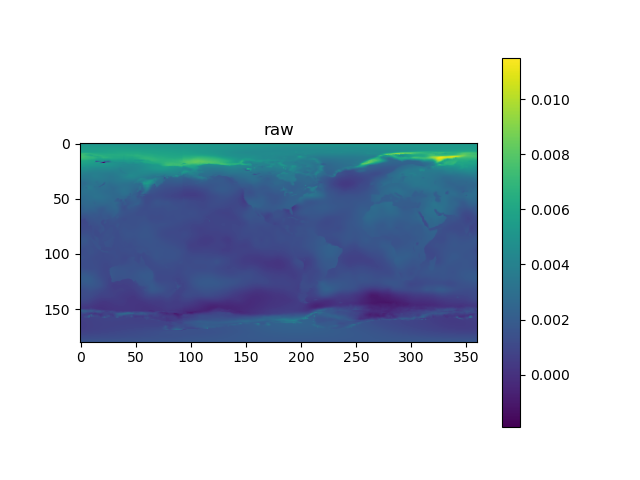

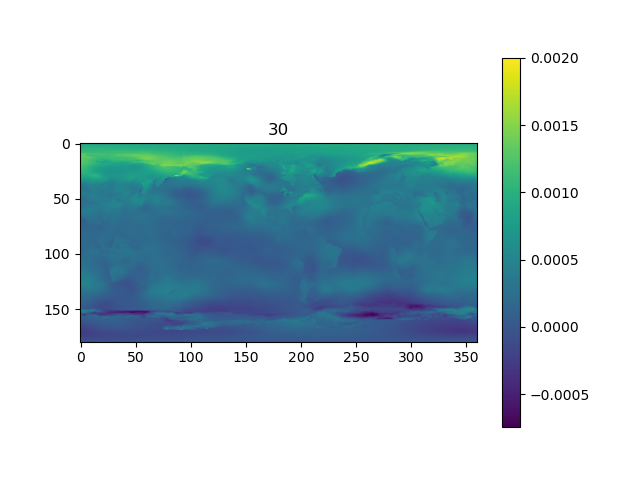

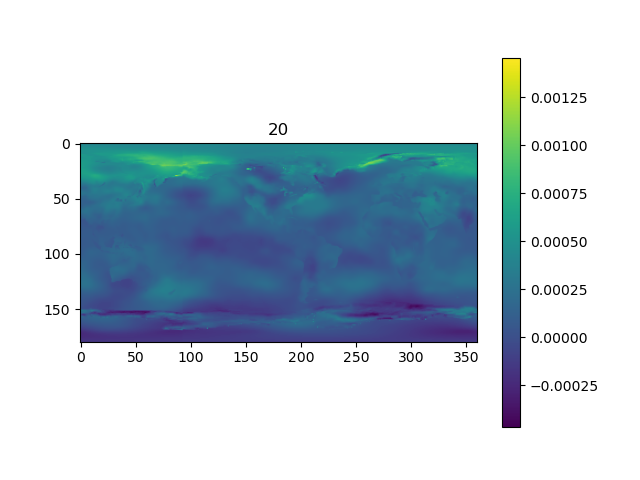

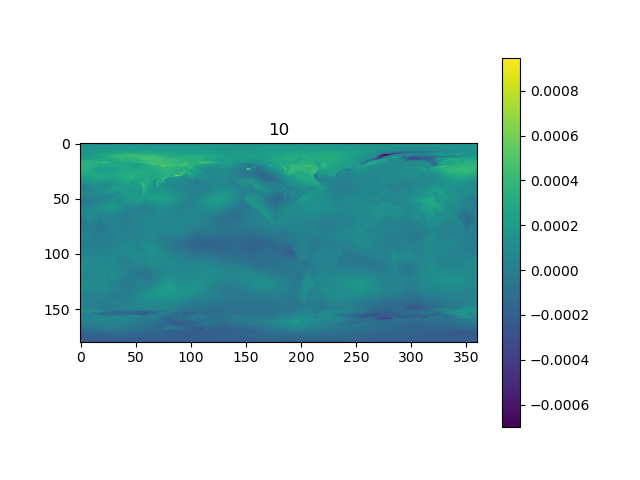

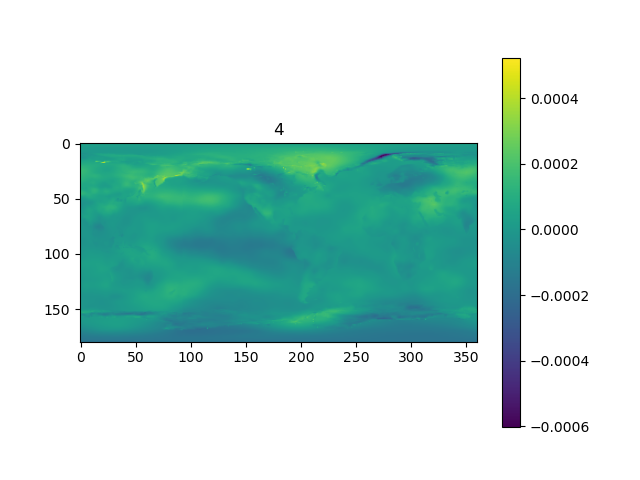

In [203]:
plt.figure()
plt.imshow(reg_grid_raw)
plt.title('raw')
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(reg_grid_30)
plt.title('30')
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(reg_grid_20)
plt.title('20')
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(reg_grid_10)
plt.title('10')
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(reg_grid_4)
plt.title('4')
plt.colorbar()

plt.show()

In [120]:
fit_30 = np.polyfit(time[:1000],np.nanmean(detrend_30[:1000],axis = (1,2)),1,cov = True)
fit_20 = np.polyfit(time[:1000],np.nanmean(detrend_20[:1000],axis = (1,2)),1,cov = True)
fit_10 = np.polyfit(time[:1000],np.nanmean(detrend_10[:1000],axis = (1,2)),1,cov = True)
fit_4 = np.polyfit(time[:1000],np.nanmean(detrend_4[:1000],axis = (1,2)),1,cov = True)
fit_raw = np.polyfit(time[:1000],np.nanmean(temp_filled[:1000],axis = (1,2)),1,cov = True)

In [130]:
print(str(fit_30[0][0])+' pm '+ str(np.sqrt(fit_30[1][0,0])))
print(str(fit_20[0][0])+' pm '+ str(np.sqrt(fit_20[1][0,0])))
print(str(fit_10[0][0])+' pm '+ str(np.sqrt(fit_10[1][0,0])))
print(str(fit_4[0][0])+' pm '+ str(np.sqrt(fit_4[1][0,0])))
print(str(fit_raw[0][0])+' pm '+ str(np.sqrt(fit_raw[1][0,0])))

-3.4243546392705065e-05 pm 2.1427870364181792e-05
-2.5634803698081904e-05 pm 2.0734338167857186e-05
-6.7179567847181796e-06 pm 2.038888700583689e-05
1.613446985055887e-05 pm 1.757257399099297e-05
0.00043138257586266084 pm 2.3013699099236354e-05


In [133]:
fit_30 = np.polyfit(time,np.nanmean(detrend_30,axis = (1,2)),1,cov = True)
fit_20 = np.polyfit(time,np.nanmean(detrend_20,axis = (1,2)),1,cov = True)
fit_10 = np.polyfit(time,np.nanmean(detrend_10,axis = (1,2)),1,cov = True)
fit_4 = np.polyfit(time,np.nanmean(detrend_4,axis = (1,2)),1,cov = True)
fit_raw = np.polyfit(time,np.nanmean(temp_filled,axis = (1,2)),1,cov = True)

In [134]:
print(str(fit_30[0][0])+' pm '+ str(np.sqrt(fit_30[1][0,0])))
print(str(fit_20[0][0])+' pm '+ str(np.sqrt(fit_20[1][0,0])))
print(str(fit_10[0][0])+' pm '+ str(np.sqrt(fit_10[1][0,0])))
print(str(fit_4[0][0])+' pm '+ str(np.sqrt(fit_4[1][0,0])))
print(str(fit_raw[0][0])+' pm '+ str(np.sqrt(fit_raw[1][0,0])))

1.1629640281206205e-05 pm 1.084628179100505e-05
4.986476747552855e-06 pm 1.0509109055040955e-05
4.637288849224895e-06 pm 1.0213421169510341e-05
1.3719322726852654e-05 pm 9.085681075713414e-06
0.0007427090986265834 pm 1.4222118378697961e-05


In [143]:
fit_30 = np.polyfit(time[:-5*12],np.nanmean(detrend_30[:-5*12],axis = (1,2)),1,cov = True)

In [144]:
fit_30

(array([-5.09919129e-06,  1.45766516e-02]),
 array([[ 1.30006177e-10, -1.07317819e-07],
        [-1.07317819e-07,  1.18154429e-04]]))